# The Renormalization group

In [1]:
using GLMakie
using CairoMakie
using OffsetArrays
using Random
using ProgressMeter
using Statistics
using DataStructures
using LinearAlgebra
using LaTeXStrings
using HDF5
using Polynomials
using DataInterpolations
using Roots
CairoMakie.activate!(type = "png")

## Coarse graining

We saw that the best way to numerically extract the phase transition point in our simulations involved *finite size scaling*.  We repeated simulations for different system sizes, and compared the results.  There is an analogous procedure, where we explore the behavior of the system under *coarse graining*.  A coarse graining procedure takes a spin configuration `s`, and returns a new configuration, `s'` with fewer degrees of freedom.  The **Renormalization Group** involves studying the behavior of the probability distributions under such coarse graining.

Clearly there are many, many ways to coarse-grain a system of spins.  Thus it is more appropriate to talk about "renormalization groups".  The other comment is that coarse-graining is typically a 1-way procedure, so we probably mean "renormalization semi-groups".  It turns out that there are properties which are independent of what coarse-graining procedure we choose.

We will consider a few coarse-graining procedures.  Lets do a simple, probabalistic one, which will divide our system size in half.  We break the system into a set of $2\times 2$ blocks, and then replace that block with a single spin.  Let $m\in\{-1,-1/2,0,1/2,1\}$ be the average magnetization of the spins in the block.  We choose our coarse-grained spin by "majority rules".  If there are more up-spins in the block then down-spins -- we choose up.  If it is a tie we flip a spin.  

We will call this transformation $R_2$ -- where the $R$ stands for rrenormalization, and the 2 tells us that we drop the linear size of the system by 2.

In [2]:
function R2(s)
    m,n=size(s)
    news=zeros(Int8,m÷2,n÷2)
    neighborhood=CartesianIndices((0:1,0:1))
    for i in CartesianIndices(news)
        sum=0
        for j in neighborhood
            sum+=s[2*i-j]
        end
        if sum>0
            news[i]=1
            continue
        end
        if sum<0
            news[i]=-1
            continue
        end
        news[i]=rand([-1,1])
    end
    return news
end

rand_ising2d(m=128, n=m) = rand(Int8[-1, 1], m, n)

rand_ising2d (generic function with 3 methods)

In [3]:
s1=rand_ising2d(4)

4×4 Matrix{Int8}:
  1   1  -1  -1
 -1  -1  -1   1
 -1   1  -1   1
  1  -1   1   1

In [4]:
R2(s1)

2×2 Matrix{Int8}:
 -1  -1
 -1   1

We then imagine having an infinite size system, in which case we can coarse-grain over and over and over.  Eventually we will get a fixed-point distribution.  For the paramagnetic state, that fixed point will just be one where each spin is independently chosen to be $1$ or $-1$.  The ferromagnet will instead consist of the two configurations where all of the spins point in the same direction.  Lets see how that works: 

In [5]:
mutable struct Sweepdata
    arraysize
    betas
    maglists
    Elists
end

function savesweep(data::Sweepdata,filename::String)
    h5open(filename,"w") do file
        write(file,"arraysize",[data.arraysize...])
        write(file,"betas",Float64[data.betas...])
        write(file,"maglists",hcat(data.maglists...))
        write(file,"Elists",hcat(data.Elists...))
    end
end

savesweep(filename::String,data::Sweepdata)=savesweep(data,filename)

function loadsweep(filename::String)
    datastream=h5open(filename, "r")
    arraysize=read(datastream["arraysize"])
    betas=read(datastream["betas"])
    maglists=read(datastream["maglists"])
    Elists=read(datastream["Elists"])
    return Sweepdata(
        Tuple(arraysize),
        betas,
        [m[:] for m in eachcol(maglists)],
        [e[:] for e in eachcol(Elists)])
end

function tempsweep(m,n,initialbeta,finalbeta,betastep,burnsweeps,outersweeps)
    s=rand_ising2d(m,n)
    β=initialbeta
    arraysize=(m,n)
    energylists=[]
    maglists=[]
    betalist=[]
    while β*betastep<=finalbeta*betastep  #multiply be betastep so get right condition when betastep is negative
        run=fullsimulate!(s,β,0.,burnsweeps,outersweeps)
        push!(energylists,run.Elist)
        push!(maglists,run.maglist)
        push!(betalist,β)
        β+=betastep
    end
    return Sweepdata(arraysize,betalist,maglists,energylists)
end 

function stats(timeseries)
    m=mean(timeseries)
    len=length(timeseries)
    numbins=10
    binlength=floor(Int64,len/numbins)
    bins=[sum(timeseries[j+1:j+binlength])/binlength for j in 0:binlength:(numbins-1)*binlength]
    err=sqrt((bins⋅bins-numbins*m^2)/numbins^2)
    return m,err
end

stats(obj,key::Symbol,transform)=
    [stats(transform(ser)) for ser in getfield(obj,key)]

@inline function pushneighbors!(neighbors,ind,sz)
    i=ind[1]
    j=ind[2]
    (m,n)=sz
    τ₁=CartesianIndex(mod1(i-1,m),j)
    τ₂=CartesianIndex(mod1(i+1,m),j)
    τ₃=CartesianIndex(i,mod1(j-1,n))
    τ₄=CartesianIndex(i,mod1(j+1,n))
    push!(neighbors,τ₁)
    push!(neighbors,τ₂)
    push!(neighbors,τ₃)
    push!(neighbors,τ₄)
end

function wolfupdate!(s,pbar #=exp(-2beta)=#,numclusters)
    m, n = sz = size(s)
    numflipped=0
    neighbors=CartesianIndex{2}[]
    loc=rand(CartesianIndices(sz))
    for sweep in 1:numclusters
        loc=rand(CartesianIndices(sz))
        σ=s[loc]
        s[loc]=-σ
        numflipped+=1
        pushneighbors!(neighbors,loc,sz)
        while length(neighbors)>0
            nb=pop!(neighbors)
            if s[nb]!=σ 
                continue
            end
            if rand()<pbar
                continue
            end
            s[nb]=-σ
            numflipped+=1
            pushneighbors!(neighbors,nb,sz)
        end
    end
    return numflipped
end 

function wolfsimulate(m::Int64,n::Int64,β::Float64,h::Float64,
        innersweeps::Int64,outersweeps::Int64)
    s=rand_ising2d(m,n)
    wolfsimulate!(s,β,h,innersweeps,outersweeps)
end

function wolfsimulate!(s,β::Float64,h::Float64,
        innersweeps::Int64,outersweeps::Int64)
    # First generate the probability distribution

    pbar=exp(-2*β)
    
    # Create empty lists for storing the energies and magnetizations

    Elist=Float64[]
    maglist=Float64[]
    fliplist=Float64[]

    # next do the outer loop
    for outer in 1:outersweeps
        # 
        f=wolfupdate!(s,pbar,innersweeps)
        E=Energy(s,h)
        mag=Magnetization(s)
        push!(Elist,E)
        push!(maglist,mag)
        push!(fliplist,f)
        # call randlocalupdate!
        # then calcualte/store E and m in the lists

    end

    return (Elist=Elist ,maglist=maglist, 
        fliplist=fliplist,dims=size(s) ,β=β ,h=0 ,innersweeps=innersweeps)
end

function Energy(s #=spin configuration=#,h)
    m, n = size(s)
    E=0.
    @inbounds for i in 1:m
        @inbounds for j in 1:n
            E+=-s[i,j]*(h+s[mod1(i+1,m),j]+s[i,mod1(j+1,n)])
        end
    end
    return E/(m*n)
end

Magnetization(s#=spin configuration=#)=mean(s)

rand_ising2d(m=128, n=m) = rand(Int8[-1, 1], m, n)

function fullsimulate!(
        s,β::Float64,h::Float64,
        burnsweeps::Int64,outersweeps::Int64)
    m,n=size(s)
    # do a short run to extract average cluster size
    shortrun=wolfsimulate!(s,β,0.,10,1)
    averageclustersize=mean(shortrun.fliplist)/10
    innersweeps=round(Int64,m*n/averageclustersize)
    if burnsweeps*innersweeps>10
        # complete the burn
        burnsteps=burnsweeps*innersweeps-10
        burn=wolfsimulate!(s,β,0.,burnsweeps*innersweeps-10,1)
    end
    # do another short run to 
    # extract new average cluster size
    shortrun=wolfsimulate!(s,β,0.,10,1)
    averageclustersize=mean(shortrun.fliplist)/10
    # do final run of algorithm
    innersweeps=ceil(Int64,m*n/(10*averageclustersize))
    result=wolfsimulate!(s,β,0.,innersweeps,outersweeps)
    return(;result...,innersweeps=innersweeps)
end

mutable struct Bin
    min ::Float64
    max ::Float64
    step ::Float64
    counts ::Array{Int64,1}
    under ::Int64
    over ::Int64
end

## Constructors

### Basic Constructor
function Bin(min,max,numbins)
    step=(max-min)/numbins
    counts=zeros(Int64,numbins)
    Bin(min,max,step,counts,0,0)
end

### Named Constructor -- allowing one to specify either numbins or step
function Bin(;min,max,numbins=0,step=0)
    if numbins==0 && step==0
        throw("Bin must be constructed with either `numbin` or `step` arguments")
    end
    if step==0
        return Bin(min,max,numbins)
    end
    numbins=Int64(round((max-min)/step))
    MAX=min+numbins*step
    return Bin(min,MAX,numbins)
end

function (b::Bin)(val)
    if val<b.min
        b.under+=1
        return b
    end
    if val>=b.max
        b.over+=1
        return b
    end
    bnum=1+Int64(floor((val-b.min)/b.step))
    b.counts[bnum]+=1
    return b
end

Base.push!(b::Bin,val)=b(val)

function freeenergy(timeseries,beta,numspins,minx,maxx,numbins)
    bin=Bin(minx,maxx,numbins)
    for x in timeseries
        bin(x)
    end
    binedges=range(minx,maxx,numbins)
    bincenters=(binedges[2:end]+binedges[1:end-1])/2
    counts=bin.counts
    xvals=[]
    fvals=[]
    err=[]
    maxcount=max(counts...)
    for j in 1:length(bincenters)
        c=counts[j]
        if c>0
            f=(-1/beta)*log(c/maxcount)/(numspins)
            df=-1/(beta*numspins*sqrt(c))
            append!(xvals,bincenters[j])
            append!(fvals,f)
            append!(err,df)
        end
    end
    return (xvals=[xvals...],fvals=[fvals...],err=[err...])
end 

freeenergy (generic function with 1 method)

  2.152921 seconds (165.60 k allocations: 11.023 MiB, 3.96% compilation time)


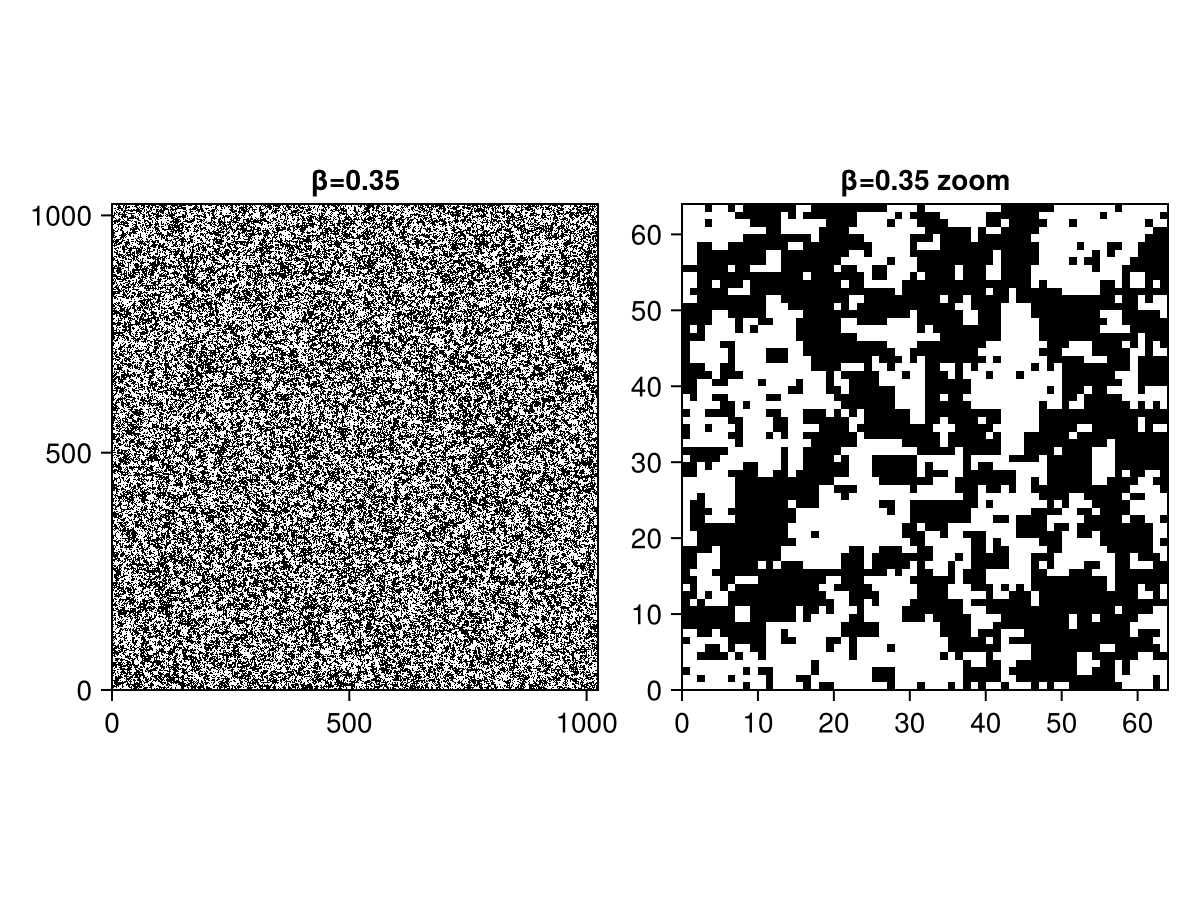

In [6]:
s=rand_ising2d(2^10)
@time fullsimulate!(s,0.35,0.,10,1)
fig=Figure()
ax=Axis(fig[1,1],aspect=1,title="β=0.35")
image!(ax,s,interpolate=false)
ax2=Axis(fig[1,2],aspect=1,title="β=0.35 zoom")
image!(ax2,s[1:64,1:64],interpolate=false)
fig

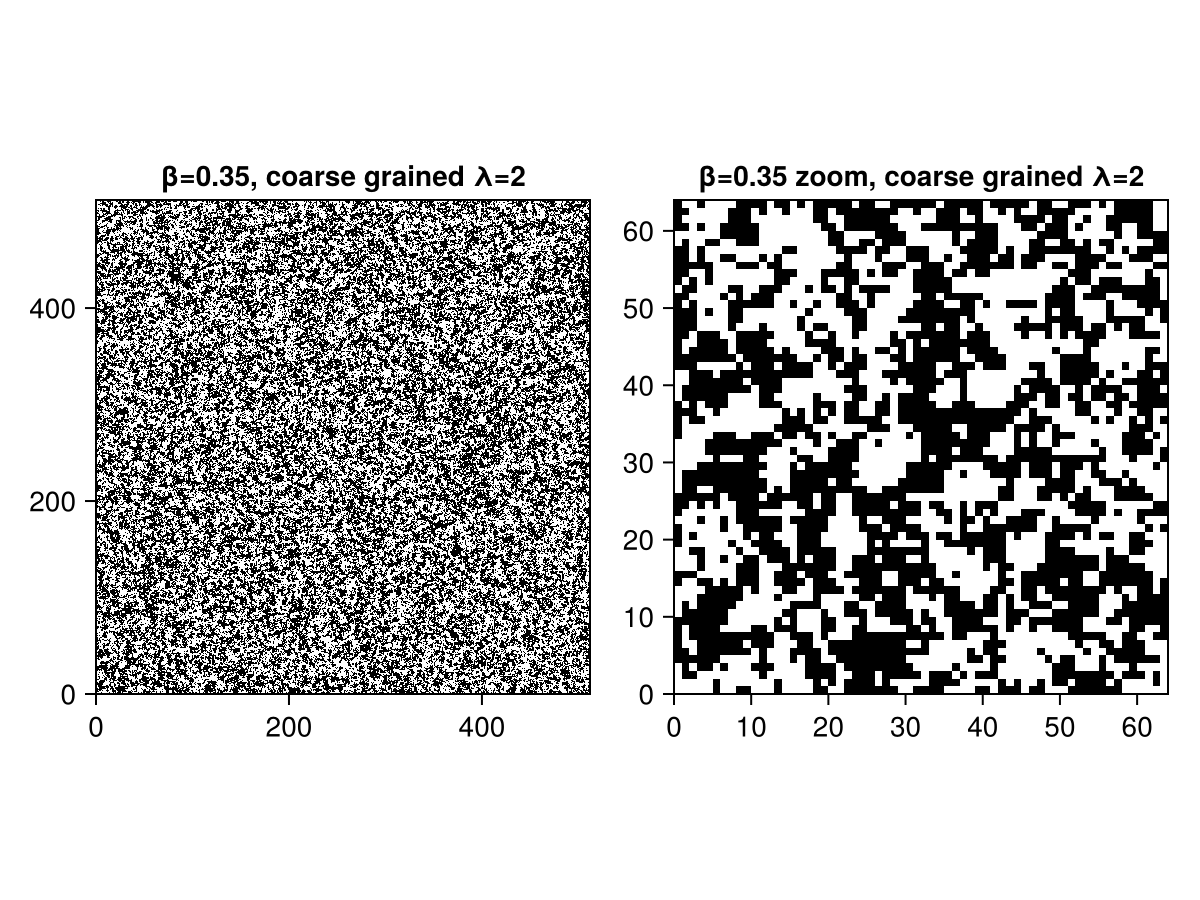

In [7]:
s2=R2(s)
fig=Figure()
ax=Axis(fig[1,1],aspect=1,title="β=0.35, coarse grained λ=2")
image!(ax,s2,interpolate=false)
ax2=Axis(fig[1,2],aspect=1,title="β=0.35 zoom, coarse grained λ=2")
image!(ax2,s2[1:64,1:64],interpolate=false)
fig

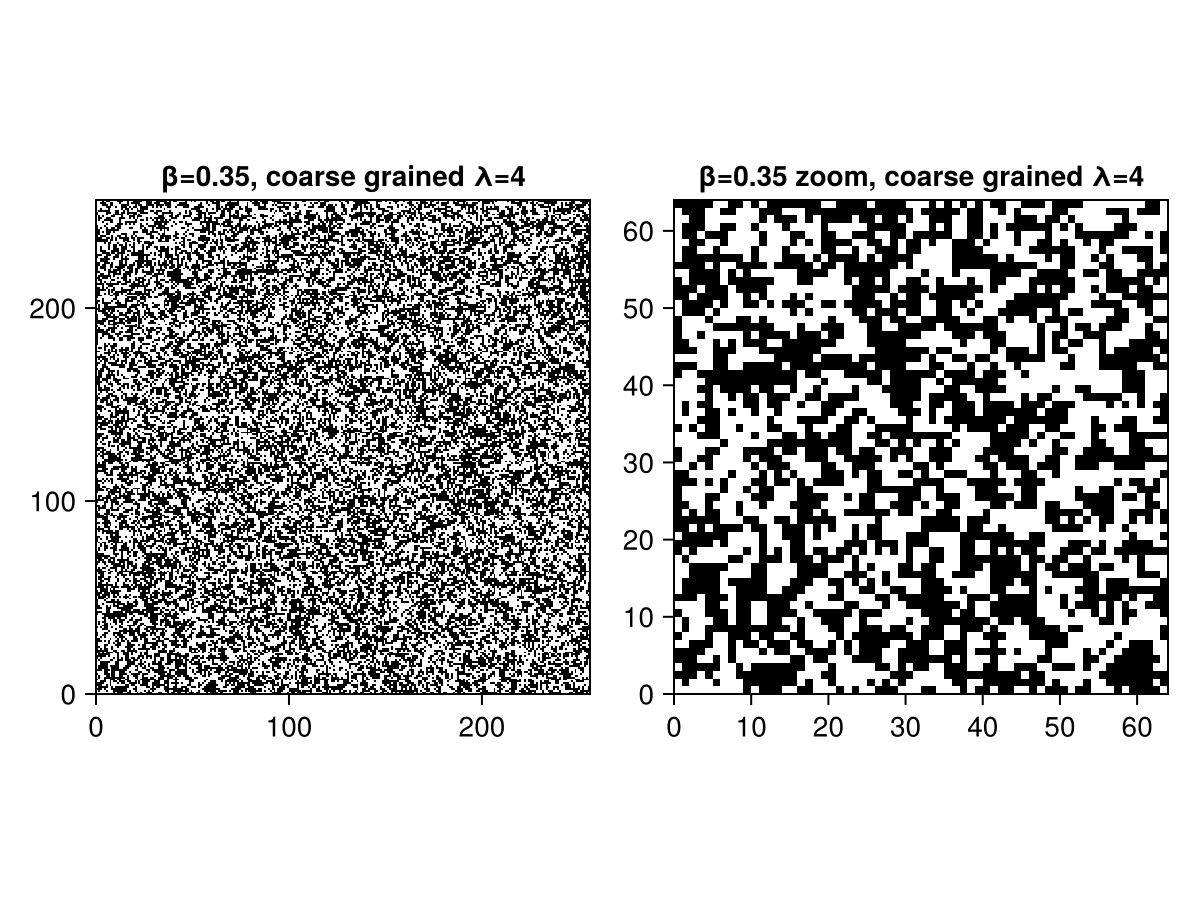

In [8]:
s3=R2(s2)
fig=Figure()
ax=Axis(fig[1,1],aspect=1,title="β=0.35, coarse grained λ=4")
image!(ax,s3,interpolate=false)
ax2=Axis(fig[1,2],aspect=1,title="β=0.35 zoom, coarse grained λ=4")
image!(ax2,s3[1:64,1:64],interpolate=false)
fig

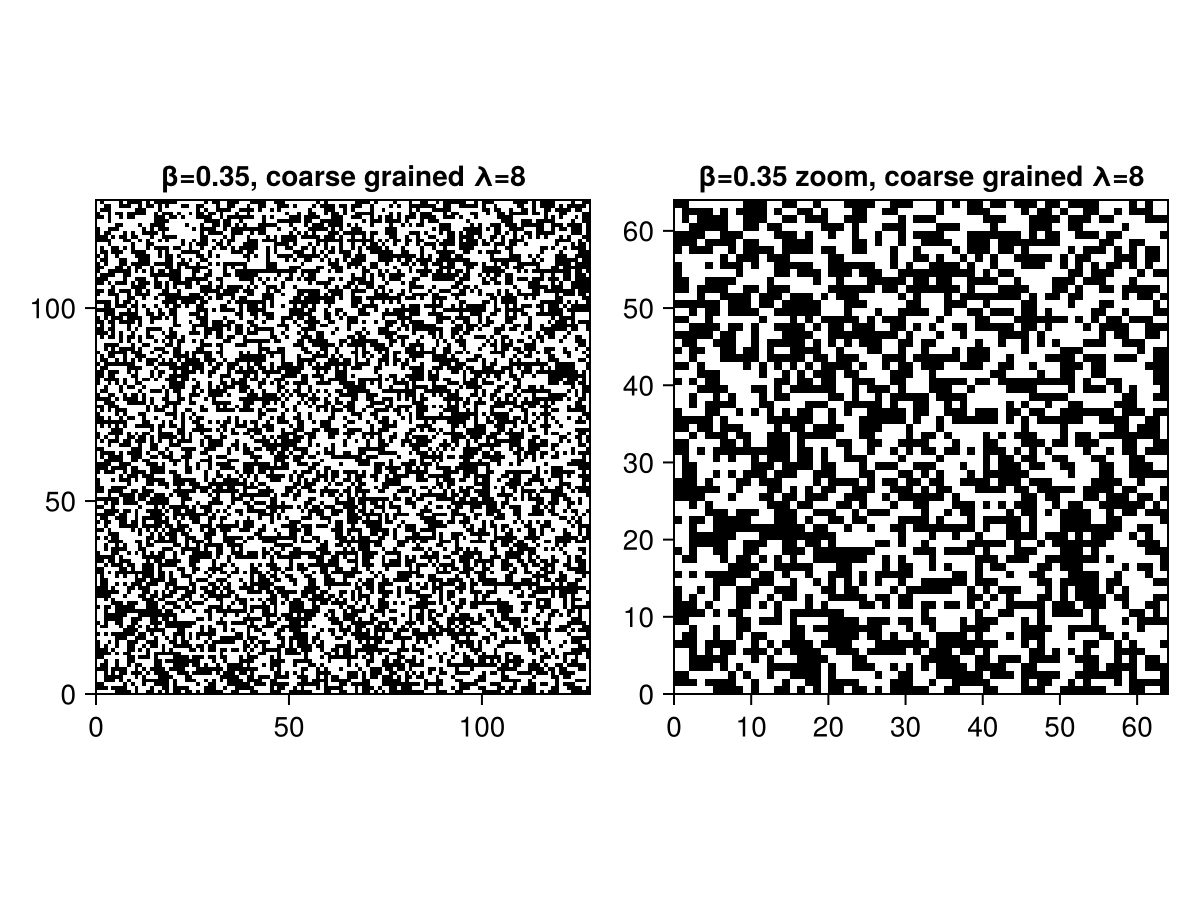

In [9]:
s4=R2(s3)
fig=Figure()
ax=Axis(fig[1,1],aspect=1,title="β=0.35, coarse grained λ=8")
image!(ax,s4,interpolate=false)
ax2=Axis(fig[1,2],aspect=1,title="β=0.35 zoom, coarse grained λ=8")
image!(ax2,s4[1:64,1:64],interpolate=false)
fig

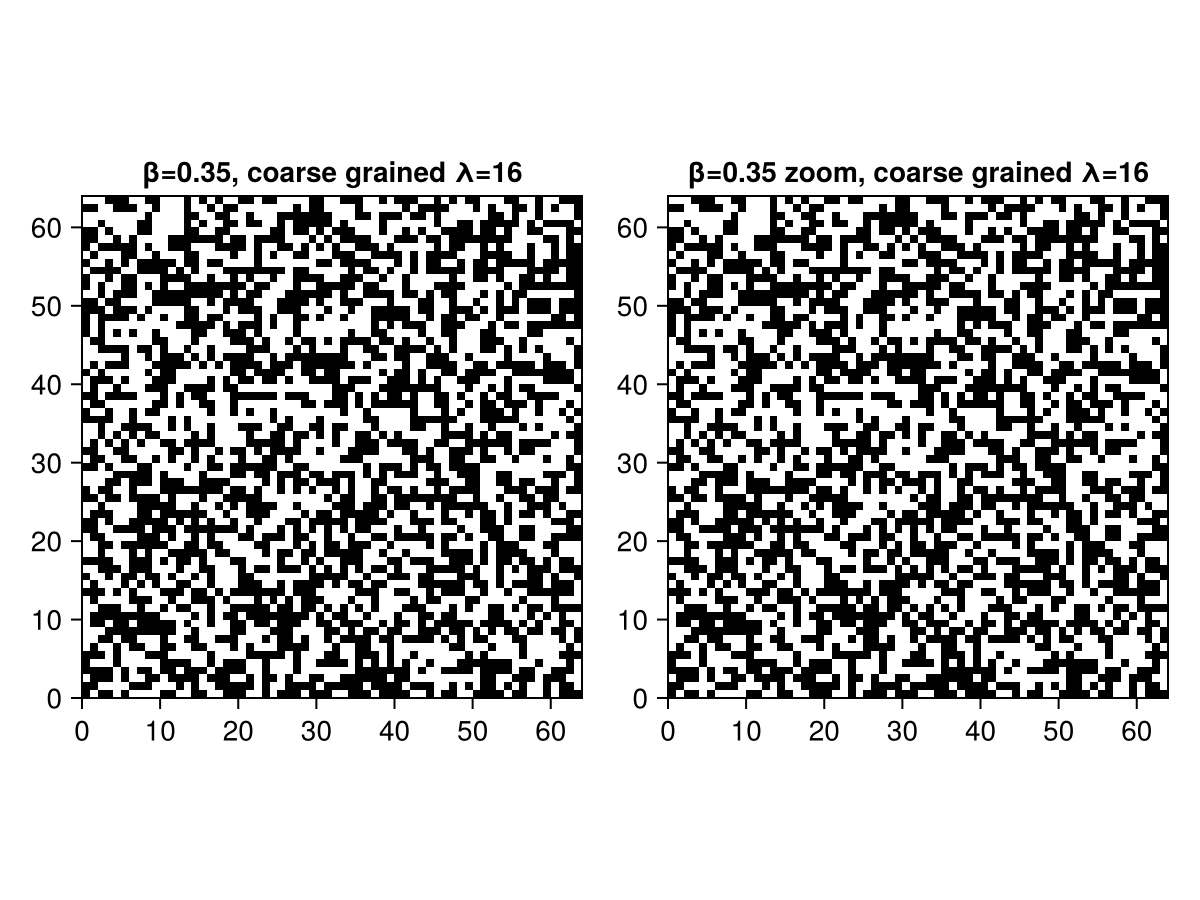

In [10]:
s5=R2(s4)
fig=Figure()
ax=Axis(fig[1,1],aspect=1,title="β=0.35, coarse grained λ=16")
image!(ax,s5,interpolate=false)
ax2=Axis(fig[1,2],aspect=1,title="β=0.35 zoom, coarse grained λ=16")
image!(ax2,s5[1:64,1:64],interpolate=false)
fig

Clearly by $\lambda=8$ we have gotten a random pattern.  In the paramagnetic phase the distribution of states always scales to the set of independent random spins.

Lets now do an ordered state

  1.366449 seconds (58 allocations: 31.363 MiB)


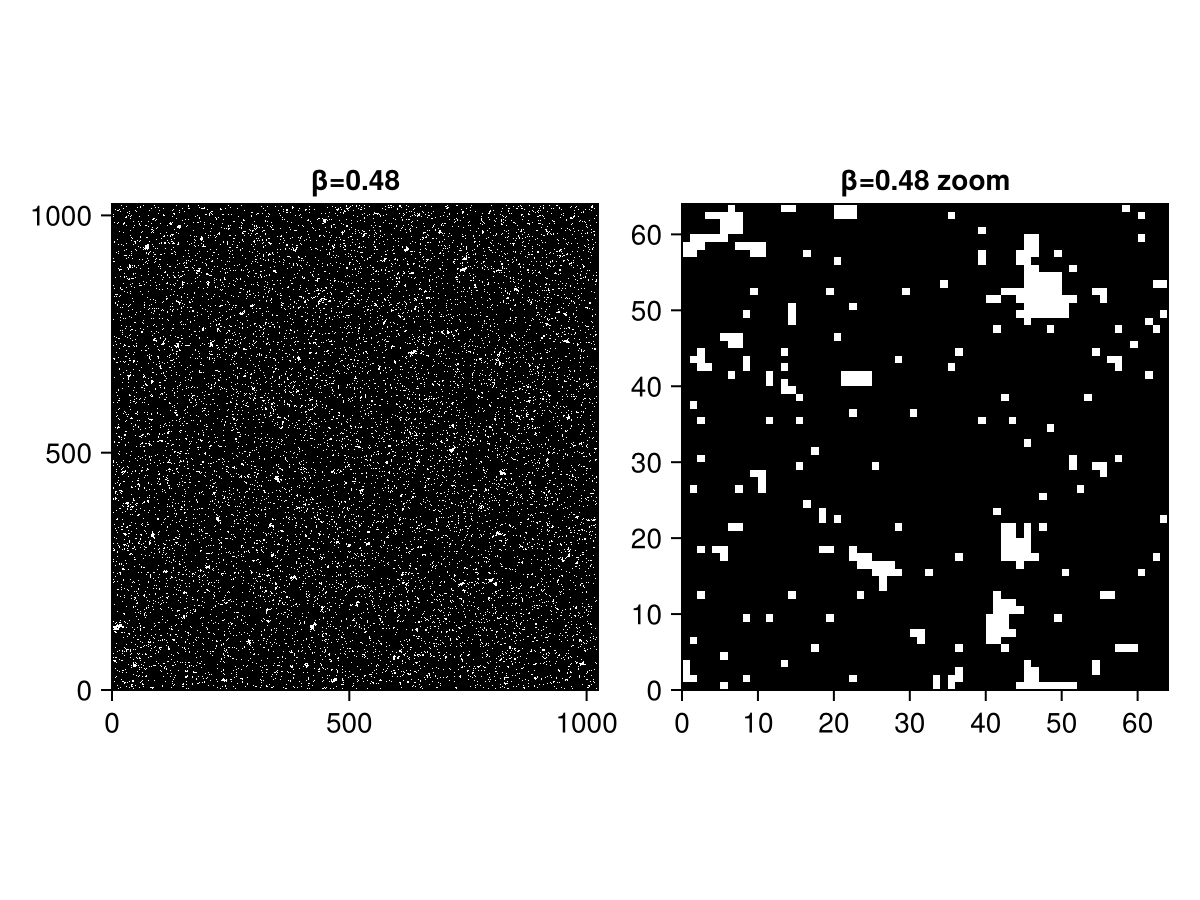

In [11]:
sc=ones(Int8,2^10,2^10)
@time fullsimulate!(sc,0.48,0.,10,1)
fig=Figure()
ax=Axis(fig[1,1],aspect=1,title="β=0.48")
image!(ax,sc,interpolate=false)
ax2=Axis(fig[1,2],aspect=1,title="β=0.48 zoom")
image!(ax2,sc[1:64,1:64],interpolate=false)
fig

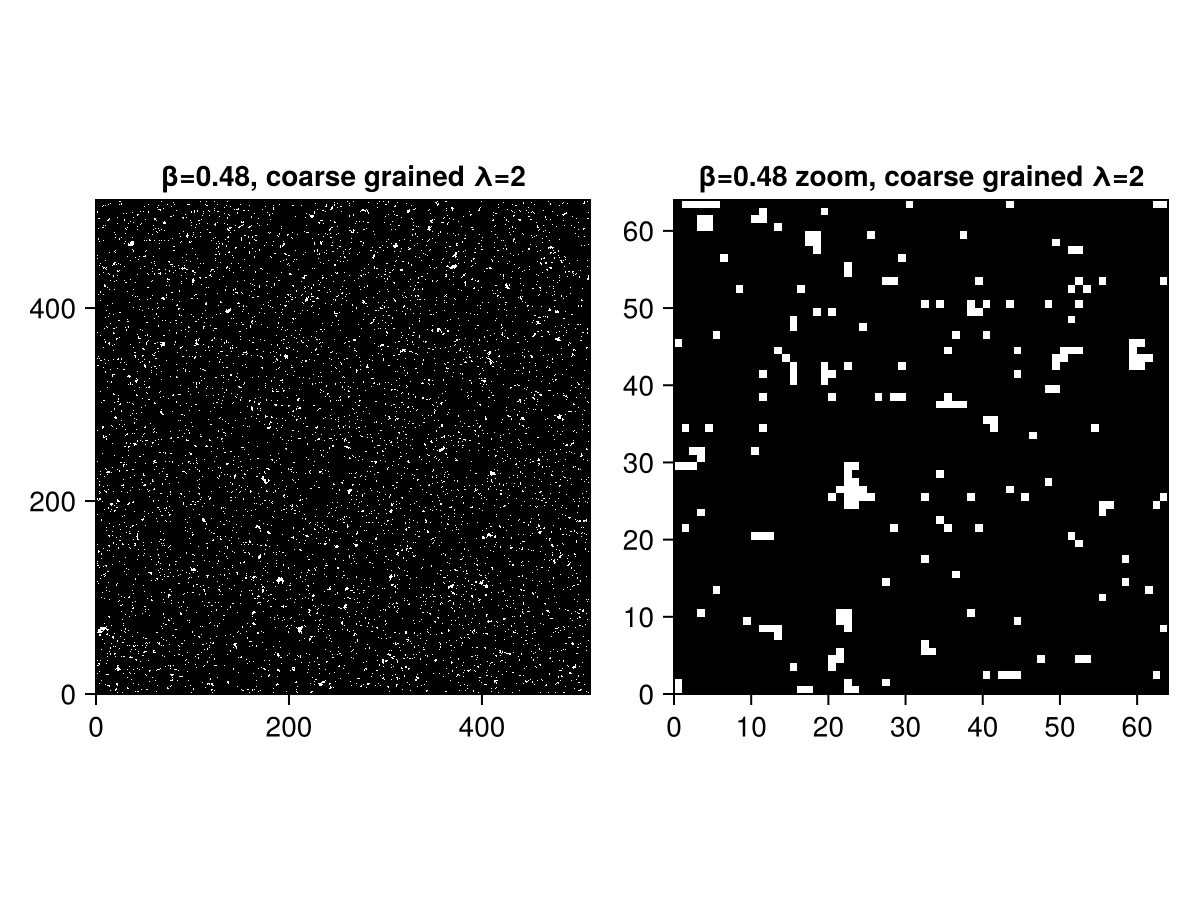

In [12]:
sc2=R2(sc)
fig=Figure()
ax=Axis(fig[1,1],aspect=1,title="β=0.48, coarse grained λ=2")
image!(ax,sc2,interpolate=false)
ax2=Axis(fig[1,2],aspect=1,title="β=0.48 zoom, coarse grained λ=2")
image!(ax2,sc2[1:64,1:64],interpolate=false)
fig

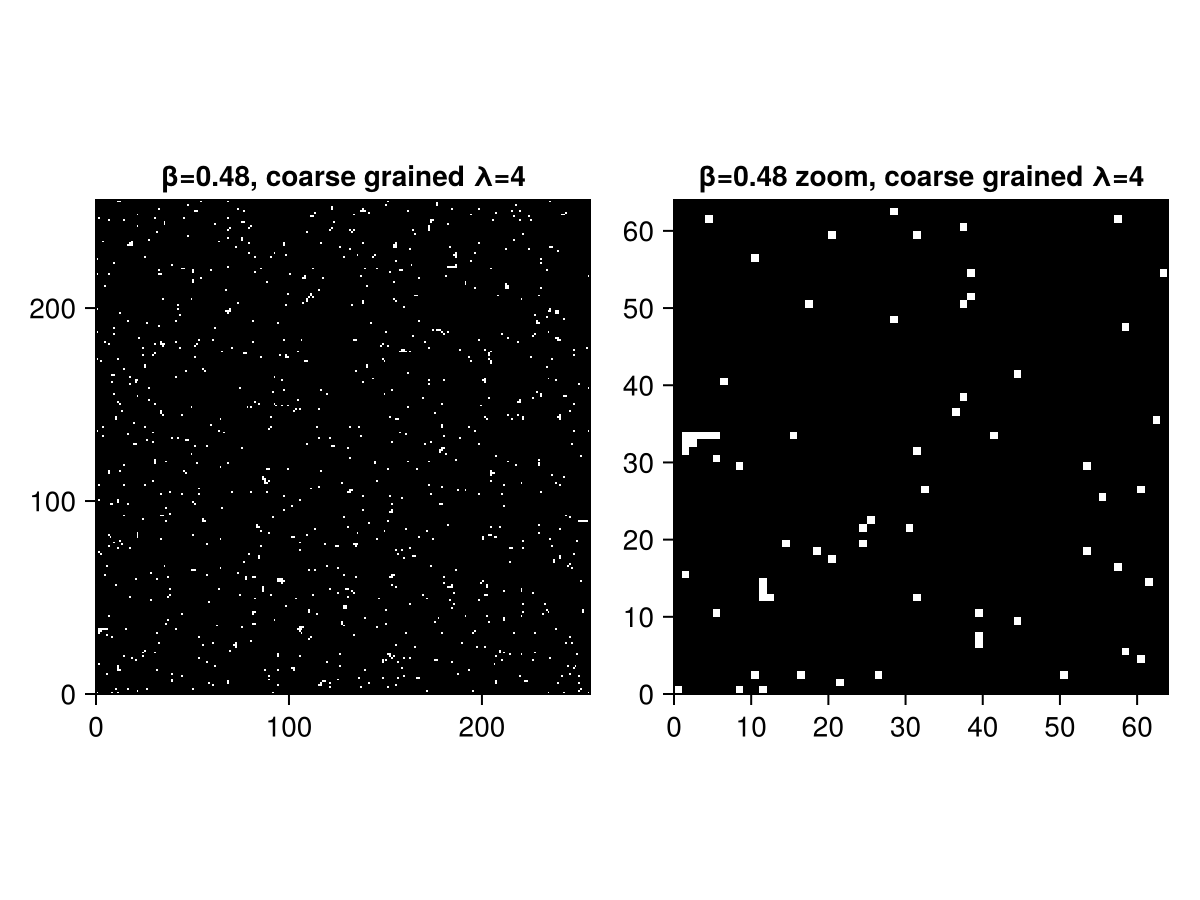

In [13]:
sc3=R2(sc2)
fig=Figure()
ax=Axis(fig[1,1],aspect=1,title="β=0.48, coarse grained λ=4")
image!(ax,sc3,interpolate=false)
ax2=Axis(fig[1,2],aspect=1,title="β=0.48 zoom, coarse grained λ=4")
image!(ax2,sc3[1:64,1:64],interpolate=false)
fig

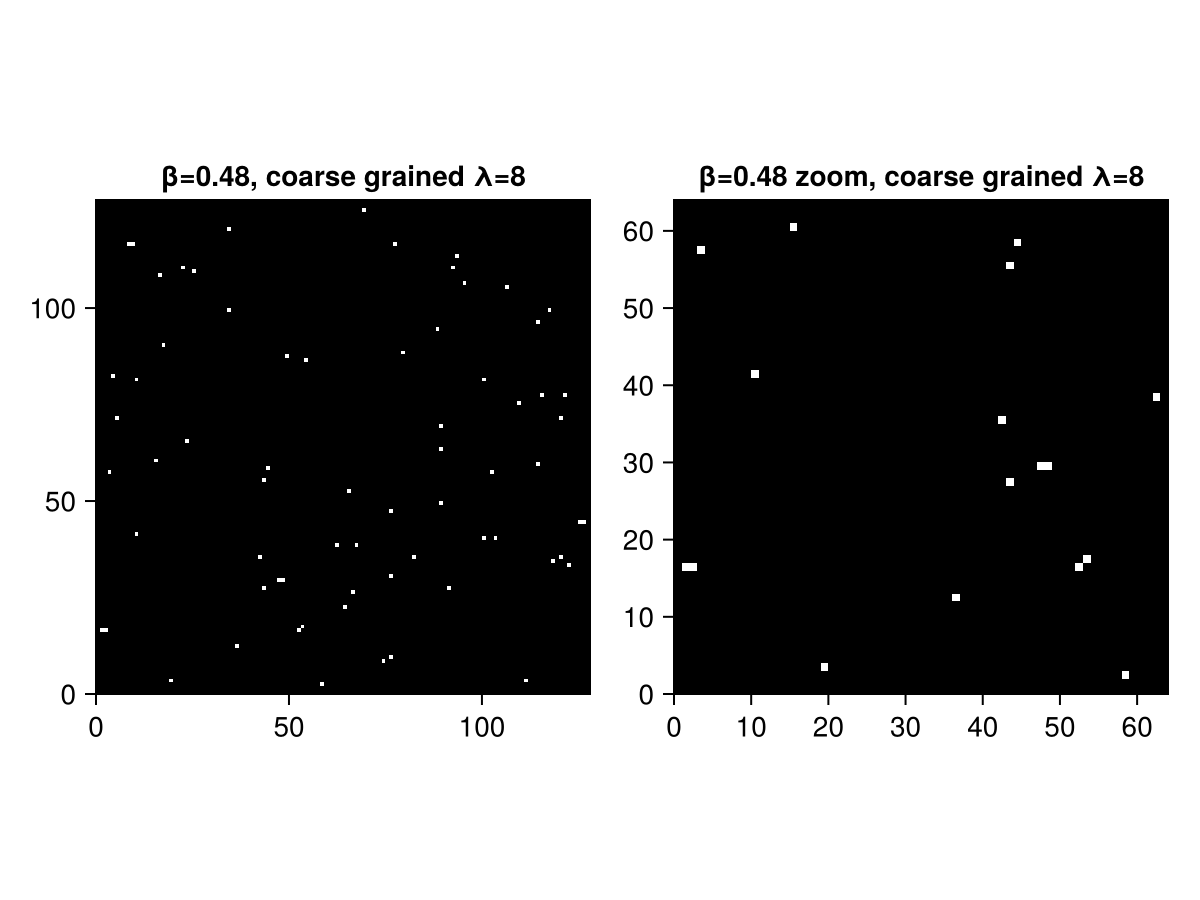

In [14]:
sc4=R2(sc3)
fig=Figure()
ax=Axis(fig[1,1],aspect=1,title="β=0.48, coarse grained λ=8")
image!(ax,sc4,interpolate=false)
ax2=Axis(fig[1,2],aspect=1,title="β=0.48 zoom, coarse grained λ=8")
image!(ax2,sc4[1:64,1:64],interpolate=false)
fig

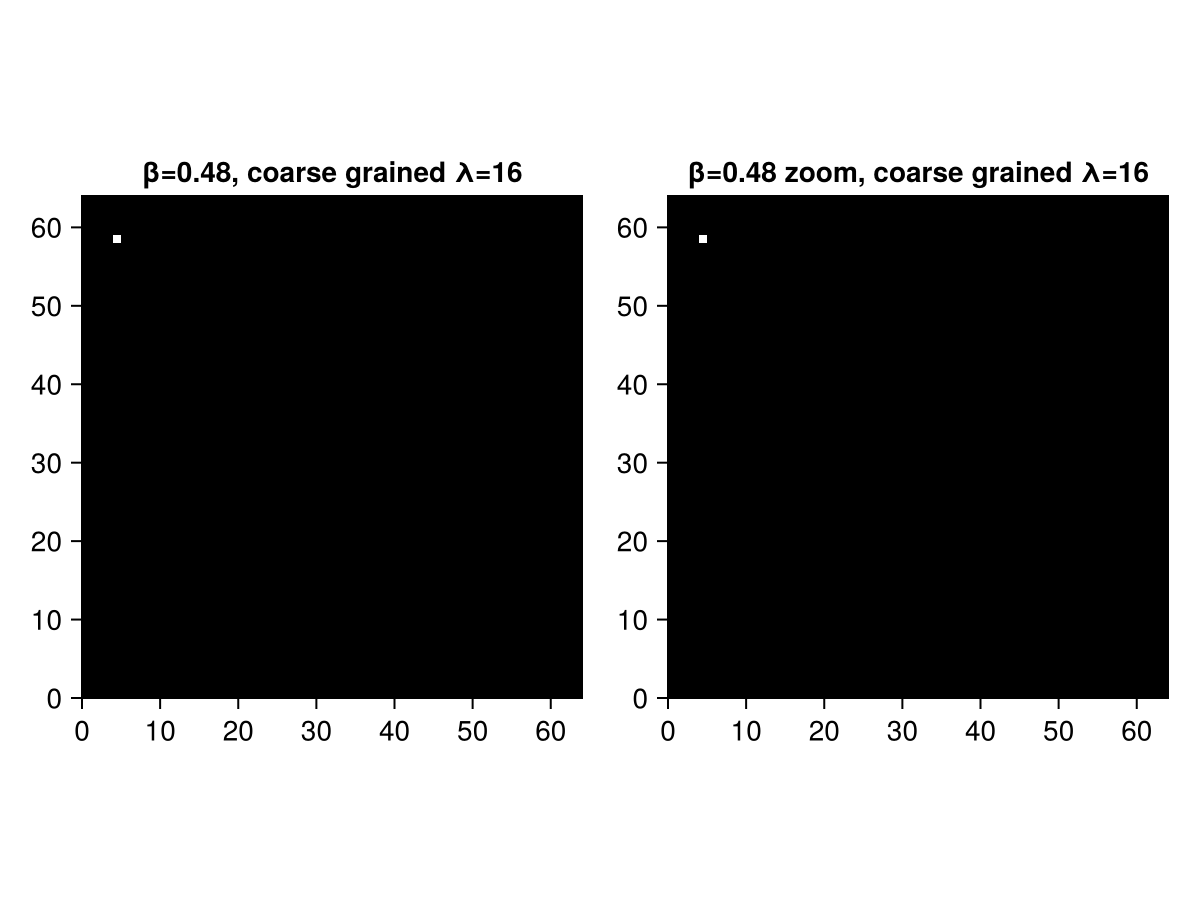

In [15]:
sc5=R2(sc4)
fig=Figure()
ax=Axis(fig[1,1],aspect=1,title="β=0.48, coarse grained λ=16")
image!(ax,sc5,interpolate=false)
ax2=Axis(fig[1,2],aspect=1,title="β=0.48 zoom, coarse grained λ=16")
image!(ax2,sc5[1:64,1:64],interpolate=false)
fig

Again -- under coarse-graining this evolves to the uniform state.  Whenever $T<T_c$ one will evolve to this configuration (or the one with all the spins flipped).

## Flows in the space of probability distributions

Coarse-graining can be viewed as a map on the space of probability distributions.  Now the space of probability distributions is really really big -- so it is hard to visualize that map.  Schematically I can pretend to draw two axes, which are supposed to be representitive.  For example one axis could be $\langle |m|\rangle$.  Another axis could be $\langle m^2\rangle$.  There are also axes which are the correlations between spins on different sites. 

The traditional parameterization of the probability space, which we will not use, is to paramerize the probabilities by the Hamiltonian for which that distribution is the thermal distribution.  For example, by adjusting $J$, adding next-nearest neighbor couplings, adding 3-spin couplings... one can in principle generate any distribution.  Thus course graining can be turned into a map in the space of Hamiltonians.

We will not take that approach here.  Since we are literally sampling the distribution functions -- and literally coarse graining the realizations -- it is more convenient for us to just work with an un-named and abstract space of distributions.

The probability distributions for the Ising model form a 1D line in this high dimensional space -- parameterized by $\beta$.  All of the distributions with $\beta<\beta_c$ flow to the high temperature fixed point.  All of the distributions with $\beta>\beta_c$ flow to the low temperature fixed point.

<img src="https://docs.google.com/drawings/d/e/2PACX-1vQ2hsnbUfc-nYDyH4y-w7n0PY9mizrpUCMMVoqw7I2PUTJYiSryPTIFvt_xNGPW8vB2_v0pxtptw0nj/pub?w=948&amp;h=469">

You many take issue with a few things about my sketch:  Why did I draw the Ising Model space as a curved line, rather than a straight line?  That was arbitrary -- I didn't specify the space, so I the embedding is pretty generic.  Next, our coarse graining procedure is discrete.  Thus rather than continuous flows in this space we are moving in discrete steps.  At this schematic level, that is a minor distinction.  

If points with $T<T_c$ scale to the low temperature fixed point, and points with $T>T_c$ flow to the high temperature fixed point, where do points at $T_c$ flow.  Well, they must have their own fixed point -- which generically is not on the original line.  

<img src="https://docs.google.com/drawings/d/e/2PACX-1vSpW2FYc47ZYuPD8JMKfi-M7TuIvNlVozkL8U6-62O8uVMDqowM2WlgYAFeGp8Tsel5ErS6cTnrYVSW/pub?w=952&amp;h=549">

The space of points which flow to this critical fixed point is referred to as the *critical manifold*.

The critical fixed point must be unstable, as we know neighboring points flow to either the high or low temperature fixed point.  Thus we can complete the schematic flow diagram in the space of probability distributions:

<img src="https://docs.google.com/drawings/d/e/2PACX-1vQLT39RrF0IS_rPz2cVqI_dXaRK-t3rdGhc7Nzf3LJ3BJkbDRLfFlJmLepKK0sGNKD5AkOsrGpXOfXI/pub?w=950&amp;h=536">

As you see, near the critical manifold the flows squeeze in some directions (called irrelevant), and stretch in others (called relevant). 

One important feature of this picture is that many different physical models can coarse-grain to the same fixed points. Thus, once coarse grained, they look the same.  For example, we expect that if we add next-nearest coupling to the Ising model, then the critical behavior will be unchanged.  This leads to the idea of *universality classes*:  Classes of models which flow to the same fixed points.

Here now comes the technical part.  Suppose we start with the Ising model at two different $\beta$'s, near $T_c$, and we coarse-grain them by a large scale $L=2^n$, where $n$ is the number of times we repeated our procedure.  If we started very very close to $T_c$, then we will end up near the fixed point.

Let $\vec K$ be a vector in the space of probability distributions, and $\vec K^*$ be the fixed point of the coarse graining procedure.  The coarse graining is a map $\vec{K}_n= R(\vec{K}_{n-1})$.  The fixed points obey $\vec K^*=R(\vec K^*)$.

Since we are going to end up near the critical point, we can linearize around it,  Let $\vec K=\vec K^*+\vec q$, where $\vec q$ is small.  We can linearize,
\begin{align}
R(\vec K^*+\vec{q})&= \vec K^*+ M \vec{q}
\end{align}
where $M$ is some matrix.  Lets diagonalize that matrix, finding $\vec k_j$ and $\lambda_j$ such that
\begin{align}
M \vec{k}_j&=\lambda_j \vec{k}_j.
\end{align}
We then expand 
\begin{align}
\vec q=\sum_j q_j \vec{k_j}, 
\end{align}
and
\begin{align}
R(\vec K^*+\vec{q})&= \vec K^*+ M \vec{q}\\
&= \vec K^*+\sum_j \lambda_j q_j \vec{k}_j
\end{align}
Thus under renormalization $q_j\to \lambda_j q_j$.  If $|\eta_j|>1$, then the perturbation grows:  These are the relevant directions.  If $|\lambda_j|<1$ the perturbation shrinks:  These are the irrelevant directions.

Now imagine that you start with an Ising model with $\beta$ near $\beta_c$.  After applying our coarse graining procedure many times we end up near the fixed point, with:
\begin{equation}
\vec K= \vec K^* + \sum_j q_j(\beta-\beta_c,\mathcal{L}) \vec{k}_j,
\end{equation}
where the coefficients $q_j$ are functions of $\beta-\beta_c$ and $\mathcal{L}=2^n$ is the scale over which we have coarse-grained.   If $\cal L$ is large, then all of the $q_j$ corresponding to irrelevant directions will be small, and can be neglected.  For simplicity, lets imagine that there is only a single relevant direction (which is reasonable for the Ising model in the absence of an external field.  Thus we can write
\begin{equation}
\vec K= \vec K^* + q_0(\beta-\beta_c,\mathcal{L}) \vec{k}_0,
\end{equation}
where $\vec{k}_0$ is the relevant direction.  We further know that if we double $\mathcal{L}$, then $q_0$ gets multiplied by $\lambda_0$.  Thus
\begin{align}
q_0(\beta-\beta_c,\mathcal{L})&= q_0(\beta-\beta_c)\lambda_0^n
\end{align}
where $n=\log_2 \mathcal{L}=\log \mathcal{L} /\log 2$.  Thus if we define $\eta_0=\log(\lambda_0)/\log(2)$ we get
\begin{align}
q_0(\beta-\beta_c,\mathcal{L})&= q_0(\beta-\beta_c) \mathcal{L}^{\eta_0}.
\end{align}
Next, we know that $q_0$ vanishes when $\beta=\beta_c$.  We can always choose our parameterization so that it vanishes linearly, in which case
\begin{align}
q_0(\beta-\beta_c,\mathcal{L})&\propto (\beta-\beta_c) \mathcal{L}^{\eta_0}.
\end{align}
Finally we use the same argument that we considered for finite size scaling:  The physical properties can only depend on the correlation length $\xi$.  Under coarse graining by scale $\mathcal{L}$, the correlation length goes as $\xi\to \xi/\mathcal{L}$, and hence we just have $\beta-\beta_c \sim \xi^{-\eta_0}$.

This is how the renormalization group is used in analytic calculations.  One finds the fixed point of the flow equations, and linearizes about them.  The critical exponents are then extracted from the eigenvalues of the linearized flow equations.

More important than giving numbers, the Renormalization Group is important because it explains two qualitative features:

- Scaling:  Near the critical point all sorts of physical quantities have power-law behavior.  This is a consequence of the fact that linearized flow equations give power laws.
- Universality:  Different physical systems, and different models, give the same critical exponents.  This is because they flow to the same fixed points.

## Flows in Hamiltonian Space

I would be remiss if I did not mention that in most of the literature one parameterizes the probability distribution by the scaled Hamiltonian $\beta H$ which gives rise to that equilibrium distribution.

Thus one usually thinks about the renormalization group flows as flows in Hamiltonian space.  Under coarse-graining you get an effective Hamiltonian.  Above $T_c$ you flow to a trivial Hamiltonian $H=0$.  Below $T_c$ you scale to a Hamiltonian which locks all of the spins together  (for example our nearest-neighbor Hamiltonian with $\beta=\infty$).  At $T_c$ you flow to some sort of "fixed point Hamiltonian".  The exact fixed point will depend on the details of your coarse graining, but the critical exponents are unique.

In this course we will stick to thinking about flows in probability space.  It is 100% equivalent, and a little more concrete.  Of course, if you have already learned about the renormalization group in the ordinary language it may require you to think a bit.

## Renormalization Group flows in finite systems

Now the natural question is, can we use these scaling arguments to find the critical point and to find critical exponent?

I am going to give an approach below -- but I caution that I have never seen exactly this approach in the literature.  There are similar arguments, but this is by no means a standard calculation. Nonetheless, we learn quite a bit about the renormalization group by using it to on simulations.

A key feature of our numerics is that we have finite systems, of linear scale $L$.  The standard way to incorporate this into the renormalization group is to consider $L$ as another *relevant* direction.  The fixed points we are interested in are at $L=\infty$.  

The idea is that we will start with two different initial system sizes $L_1$ and $L_2$ -- In our case we will take $L_2= L_1/2$.  We will then coarse-grain the first system $n$ times, and the second system $n-1$ times.  If we started at $\beta_1=\beta_c$ and $\beta_2=\beta_c$, then these should scale to identical probability distributions.  Thus we can in principle find the critical point by comparing the resulting distributions.

One challenge is how to compare distributions -- especially because these are distributions on a large number of spins.  Our solution is that we will calculate some expectation value of the distribution.  We will use the difference between these expectation values as a surrogate for the difference between the distributions.  I like our Ising model energy as a good surrogate.

Thus we will calculate $E(\beta,L,n)$ which is the expectation value of the energy of the Ising model of size $L$ after $n$ coarse graining steps.  The critical point will be where
\begin{equation}
E(\beta,L,n)=E(\beta,L/2,n-1)
\end{equation}
This equation defines $\beta^*(L,n)$.  In the limit $L\to\infty, n\to \infty$ we should have $\beta^*=\beta_c$.  In practice we don't want to make $n$ too large, as if we coarse grain too much we get trivial distrbutions.  Thus we probably want $n$ to be moderate.  

## Implementation

To implement this algorithm, we will fix $L$, and step through $\beta$.  At each $\beta$ we will generate a sequence of realizations, recording the magnetization and energy.  We will also coarse grain the realizations, recording their magnetizations and energies.

From this data we will construct an interpolating function which is $E_L(\beta,n)$.  We can also construct the inverse function, $\beta(E_L,n)$.  We wil use this inverse function later

To this end, lets write a version of our `rgsimulate!` function which also returns the coarse-grained information.

In [16]:
function rgsimulate!(
        s,β::Float64,h::Float64,
        burnsweeps::Int64,outersweeps::Int64,coarsegrainfunction,numcoarsegrainsteps)
    m,n=size(s)
    # do a short run to extract average cluster size
    shortrun=wolfsimulate!(s,β,0.,10,1)
    averageclustersize=mean(shortrun.fliplist)/10
    innersweeps=round(Int64,m*n/averageclustersize)
    if burnsweeps*innersweeps>10
        # complete the burn
        burnsteps=burnsweeps*innersweeps-10
        burn=wolfsimulate!(s,β,0.,burnsweeps*innersweeps-10,1)
    end
    # do another short run to 
    # extract new average cluster size
    shortrun=wolfsimulate!(s,β,0.,10,1)
    averageclustersize=mean(shortrun.fliplist)/10
    # do final run of algorithm
    innersweeps=ceil(Int64,m*n/(10*averageclustersize))
    #
    # Only change is this line    
    result=rgwolfsimulate!(s,β,0.,innersweeps,outersweeps,coarsegrainfunction,numcoarsegrainsteps)
    #
    return(;result...,innersweeps=innersweeps)
end

function rgwolfsimulate!(s,β::Float64,h::Float64,
        innersweeps::Int64,outersweeps::Int64,coarsegrainfunction,numcoarsegrainsteps)
    # First generate the probability distribution

    pbar=exp(-2*β)
    
    # Create empty lists for storing the energies and magnetizations

    Elist=Float64[]
    maglist=Float64[]
    fliplist=Float64[]

    # containers to hold coarse grained data
    cgElists=[Float64[] for j in 1:numcoarsegrainsteps]
    cgmaglists=[Float64[] for j in 1:numcoarsegrainsteps]

    # next do the outer loop
    for outer in 1:outersweeps
        # 
        f=wolfupdate!(s,pbar,innersweeps)
        E=Energy(s,h)
        mag=Magnetization(s)
        push!(Elist,E)
        push!(maglist,mag)
        push!(fliplist,f)
        # coarse grain
        scg=s
        for cg in 1:numcoarsegrainsteps
            scg=coarsegrainfunction(scg)
            Ecg=Energy(scg,h)
            mcg=Magnetization(scg)
            push!(cgElists[cg],Ecg)
            push!(cgmaglists[cg],mcg)
        end
    end

    return (Elist=Elist ,maglist=maglist, 
        fliplist=fliplist,dims=size(s) ,β=β ,h=0 ,innersweeps=innersweeps,cgElists=cgElists,cgmaglists=cgmaglists)
end

rgwolfsimulate! (generic function with 1 method)

In [17]:
s1=rand_ising2d(64)
@time tst1=rgsimulate!(s1,0.4,0.,10,10000,R2,2)
@time tst2=fullsimulate!(s1,0.4,0.,10,10000)

  0.844918 seconds (2.16 M allocations: 213.375 MiB, 40.97% gc time, 6.28% compilation time)
  0.368819 seconds (39.71 k allocations: 42.408 MiB)


(Elist = [-1.1337890625, -1.123046875, -1.109375, -1.0947265625, -1.0625, -1.0751953125, -1.0986328125, -1.109375, -1.1171875, -1.1142578125  …  -1.0498046875, -1.0478515625, -1.05078125, -1.0439453125, -1.064453125, -1.0732421875, -1.103515625, -1.119140625, -1.1123046875, -1.10546875], maglist = [-0.013671875, -0.06640625, -0.05712890625, -0.072265625, -0.087890625, -0.046875, -0.01904296875, 0.04443359375, -0.04150390625, -0.1484375  …  -0.10595703125, -0.08056640625, -0.08251953125, -0.06494140625, -0.09765625, 0.005859375, -0.11376953125, -0.0029296875, 0.091796875, 0.21435546875], fliplist = [160.0, 234.0, 37.0, 151.0, 160.0, 170.0, 165.0, 134.0, 178.0, 345.0  …  350.0, 66.0, 696.0, 352.0, 435.0, 226.0, 623.0, 249.0, 198.0, 403.0], dims = (64, 64), β = 0.4, h = 0, innersweeps = 6)

This works great -- but I am going to be driven insane by this data structure:

In [18]:
keys(tst1)

(:Elist, :maglist, :fliplist, :dims, :β, :h, :innersweeps, :cgElists, :cgmaglists)

To make things worse we are going to want to sweep over temperatures

In [19]:
@time tstsweep64=[rgsimulate!(s1,beta,0.,10,10000,R2,4) for beta in 0.4:0.01:0.5];

 18.271628 seconds (12.78 M allocations: 4.773 GiB, 1.10% gc time, 0.24% compilation time)


And then we are going to have another data set at a different system size

In [20]:
s1=rand_ising2d(32)
@time tstsweep32=[rgsimulate!(s1,beta,0.,10,10000,R2,3) for beta in 0.4:0.01:0.5];

  5.709599 seconds (3.61 M allocations: 1.382 GiB, 1.41% gc time, 0.38% compilation time)


Lets first write a function which when called with one of these temperature sweeps, extracts the data we care about:
We need average energy as a function of $\beta$, $L$, and $n$.

In [21]:
function rgenergydata(tempsweep)
    βlist=[data.β  for data in tempsweep]
    numβ=length(βlist)
    maxn=length(tempsweep[1].cgElists)
    # make an offset arrayg
    # first index will index the β
    # second index will index the coarse-grain depth
    #   -- starts at zero -- for no coarse graining
    aveElists=OffsetArray(zeros(numβ,maxn+1),0,-1)
    for (i,β) in pairs(βlist)
        aveElists[i,0]=mean(tempsweep[i].Elist)
        for n in 1:maxn
            aveElists[i,n]=mean(tempsweep[i].cgElists[n])
        end
    end
    L=tempsweep[1].dims[1]
    return (L=L,βlist=βlist,Elists=aveElists,maxn=maxn,
        usage="`Elists[j,n]` is energy of coarse-grained energy of system of size `"*string(L)*
            "` at inverse temperature `βlist[j]`, after `n` coarse graining steps.  `n` runs from 0"*
            " to "*string(maxn))
end 

rgenergydata (generic function with 1 method)

In [22]:
tstrgenergydata64=rgenergydata(tstsweep64)
@show keys(tstrgenergydata64)
println()
display("text/markdown",tstrgenergydata64.usage)

keys(tstrgenergydata64) = (:L, :βlist, :Elists, :maxn, :usage)



`Elists[j,n]` is energy of coarse-grained energy of system of size `64` at inverse temperature `βlist[j]`, after `n` coarse graining steps.  `n` runs from 0 to 4

Note, this may seem a little tedious.  We first generated a complicated data set -- then we did a lot of manipulation to convert it into the form that we wanted.

Alternatively, we could rewrite the `rgsimulate!` function so that it only returns the info that we want.

There are obvious trade-offs here.  If we store more information we have more flexibility with what to do with it -- but it takes more disk space, and we have to make auxilliary functions to extract the pieces we care about.

Lets now do the length 32 data

In [23]:
tstrgenergydata32=rgenergydata(tstsweep32)

(L = 32, βlist = [0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5], Elists = [-1.10681015625 -0.90289375 -0.67220625 -0.428375; -1.16616953125 -0.9905453125 -0.78770625 -0.57325; … ; -1.713142578125 -1.81943125 -1.927025 -1.984725; -1.745590625 -1.8522 -1.9478625 -1.992025], maxn = 3, usage = "`Elists[j,n]` is energy of coarse-grained energy of system of size `32` at inverse temperature `βlist[j]`, after `n` coarse graining steps.  `n` runs from 0 to 3")

Now lets plot the data

In [43]:
function plotrgdata!(ax::Axis,rgdata)
    L=rgdata.L
    βlist=rgdata.βlist
    Elists=rgdata.Elists
    maxn=rgdata.maxn
    for n in 0:maxn
        plot!(ax,βlist,Elists[:,n],
            label="L="*string(L)*" n="*string(n))
        lines!(ax,βlist,Elists[:,n])
    end
end

function plotrgpoints!(ax::Axis,rgdata)
    L=rgdata.L
    βlist=rgdata.βlist
    Elists=rgdata.Elists
    maxn=rgdata.maxn
    for n in 0:maxn
        plot!(ax,βlist,Elists[:,n],
            label="L="*string(L)*" n="*string(n))
    end
end

plotrgpoints! (generic function with 1 method)

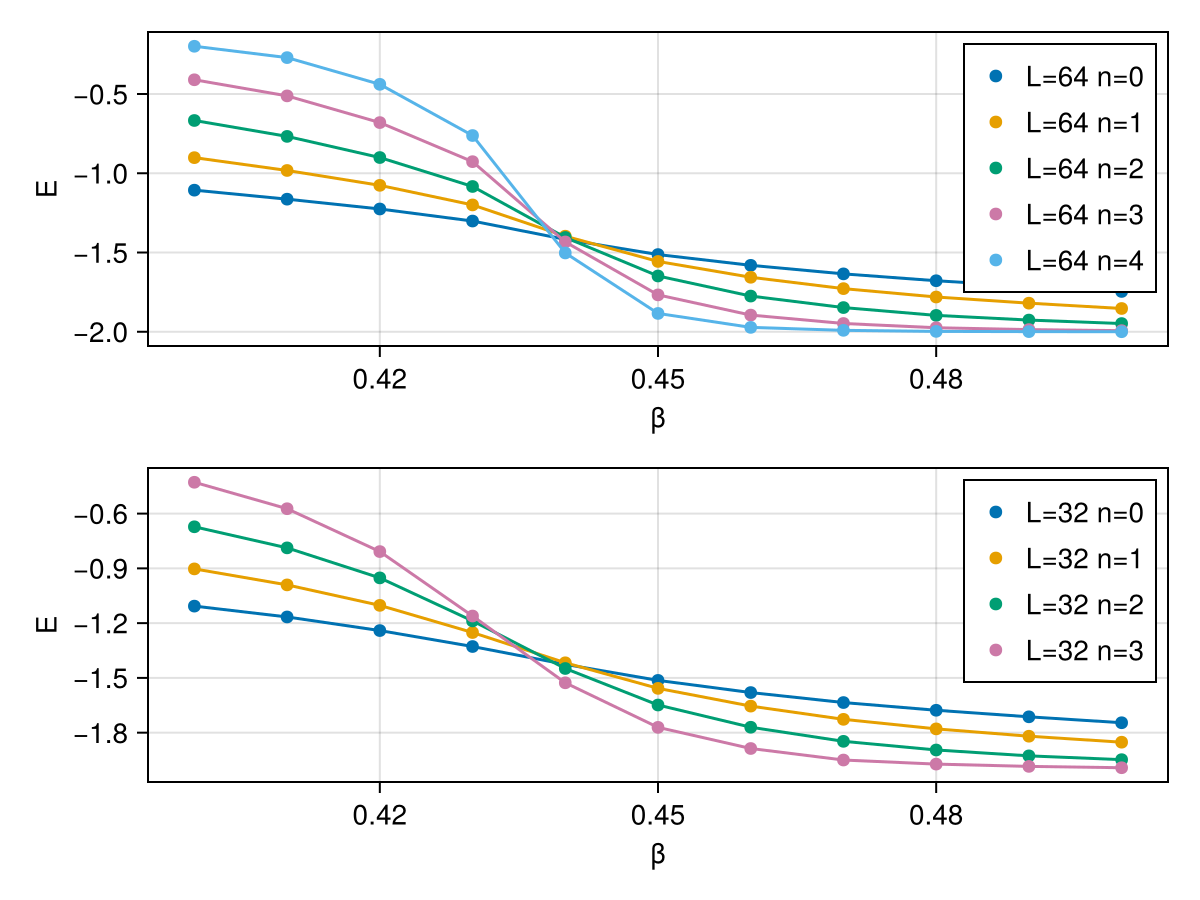

In [25]:
f=Figure()
ax1=Axis(f[1,1],xlabel="β",ylabel="E")
plotrgdata!(ax1,tstrgenergydata64)
axislegend()
ax2=Axis(f[2,1],xlabel="β",ylabel="E")
plotrgdata!(ax2,tstrgenergydata32)
axislegend()
f

As expected, when $T>T_c$, coarse graining ends up increasing the average energy, while when $T<T_c$ it decreases it

This gives an obvious way to find $T_c$ -- we just look at where a sequential coarse-graining step leaves the energy unchanged.  The simplest version is just one coarse graining step.  We would then do this for several system sizes, and extrapolate to the thermodynamic limit.  We could also systematically increase the number of coarse graining steps.

We will use a slightly better strategy where we coarse grain from different initial system sizes, and look at where they give the same distributions.

For our strategy we will need to turn these curves into interpolating functions.  We could again use polynomial fits -- but a better solution is cupic splines.  We will use a package, but it is probably useful to first discuss the theory behind splines

### Cubic Splines

Given a set of data $(x_1,y_1), (x_2,y_2)...$ we want to draw a smooth curve $y(x)$ which goes through all of those data points.  By *smooth* we mean that the function and its first two derivatives are continuous.  Clearly we want $y(x_i)=y_i$.  These points are referred to as *knots*.  To make our life easier, we will assume that the $x_j$ are equally spaced: $\delta x= x_j-x_{j-1}$.

Our strategy will be to use a piecewise polynomial.  Lets use `Polynomials.jl` for our polynomials

In [26]:
using Polynomials

In [27]:
p=Polynomial([1.,-1.])

Polynomial(1.0 - 1.0*x)

Lets now introduce a spline class which uses unformly space nodes, and has a list of functions which it uses between those nodes

In [28]:
struct upiecewise #u is for uniform
    minx
    dx
    maxx
    functions # list of the functions to evaluate in each interval
end

function (u::upiecewise)(x)
    if x<u.minx || x>u.maxx
        throw("x:$x is not between xmin:$u.minx and xmax:$u.xmax")
    end
    n=ceil(Int64,(x-u.minx)/u.dx)
    u.functions[max(n,1)](x)
end

We can then make a linear interpolation function.  If we want a function $y=y(x)$ which passes through $(x_1,y_1)$ and $(x_2,y_2)$ we can use
\begin{align}
y&=\frac{x-x_1}{x_2-x_1} y_2+\frac{x-x_2}{x_1-x_2} y_1\\
&=\frac{x_2 y_1-x_1 y_2}{x_2-x_1} + \frac{y_2-y_1}{x_2-x_1} x
\end{align}

In [29]:
function lininterp(yvalues,xmin=0,dx=1)
    # assume x values are
    functions=[]
    for j in 2:length(yvalues)
        x1=xmin+dx*(j-2)
        x2=xmin+dx*(j-1)
        y1=yvalues[j-1]
        y2=yvalues[j]
        offset= (x2*y1-x1*y2)/dx
        slope= (y2-y1)/dx
        push!(functions,Polynomial([offset,slope]))
    end
    xmax=xmin+(length(yvalues)-1)*dx
    return upiecewise(xmin,dx,xmax,functions)
end     

lininterp (generic function with 3 methods)

In [30]:
f1=lininterp([0,1,1,0])

upiecewise(0, 1, 3, Any[Polynomial(1.0*x), Polynomial(1.0), Polynomial(3.0 - 1.0*x)])

In [31]:
f1(2.5)

0.5

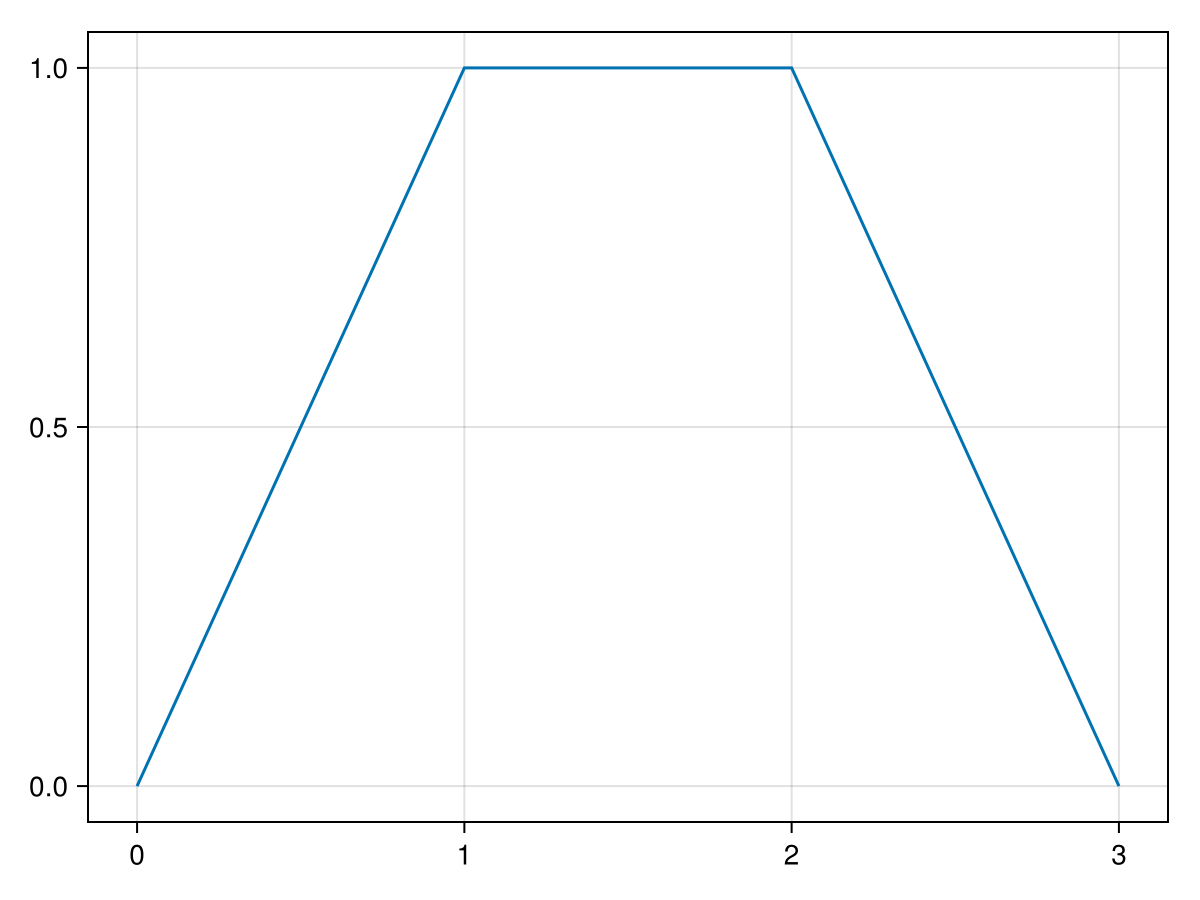

In [32]:
xvals=0:0.1:3
lines(xvals,[f1(x) for x in xvals])

Now the problem with linear interpolation is that it is not smooth.  We can solve this by using higher degree polynomials.

Consider $y(x)$ for $x_j<x<x_{j+1}$.  We need 2 degrees of freedom to set $y(x_j)=y_j$ and $y(x_{j+1})=y_{j+1}$.  That is what gives us a linear interpolation.  If we wanted to specify $y^\prime$ and $y^{\prime\prime}$ at the two boundaries, that would require 4 more degrees of freedom.  We do not, however want to constrain the value, just make them continuous.  Thus the constraint is effectively shared between the two intervals -- leading to 4 total degrees of freedom -- which is equivalent to a cubic polynomial.  That motivates cubic interpolation.

Note that in the counting the boundaries are special -- and we have an extra constraint we can apply there:  Typically we use those to make the second derivative vanish at the boundaries.

The linear algebra is a bit of a pain -- and you would lose interest if I tried to do it in front of you, so lets just use a package.

In [34]:
using DataInterpolations

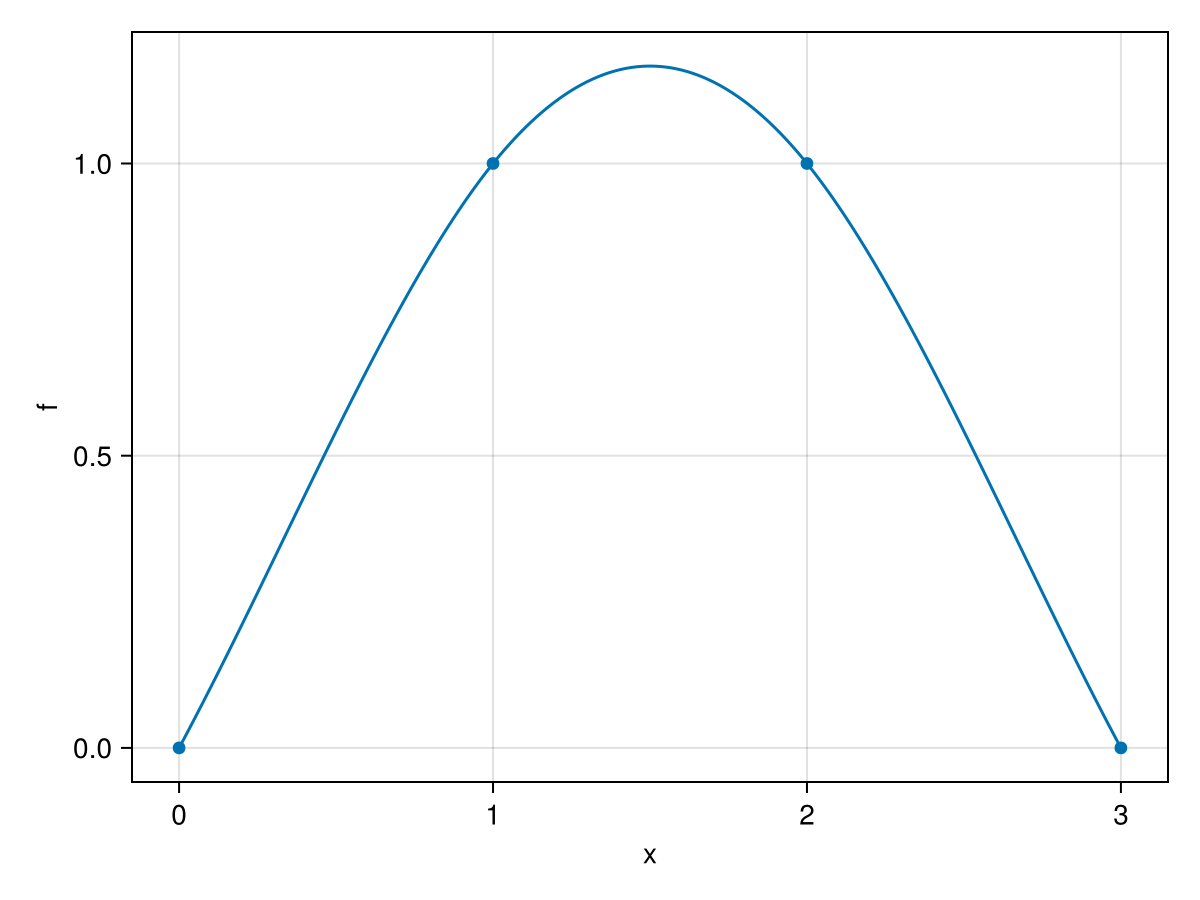

In [37]:
f2=CubicSpline([0.,1.,1.,0.],0:3)
xvals=0:0.01:3
p=lines(xvals,[f2(x) for x in xvals])
plot!(0:3,[0.,1.,1.,0.])
p.axis.xlabel="x"
p.axis.ylabel="f"
p

Here is another way to make `Makie` plot the splines

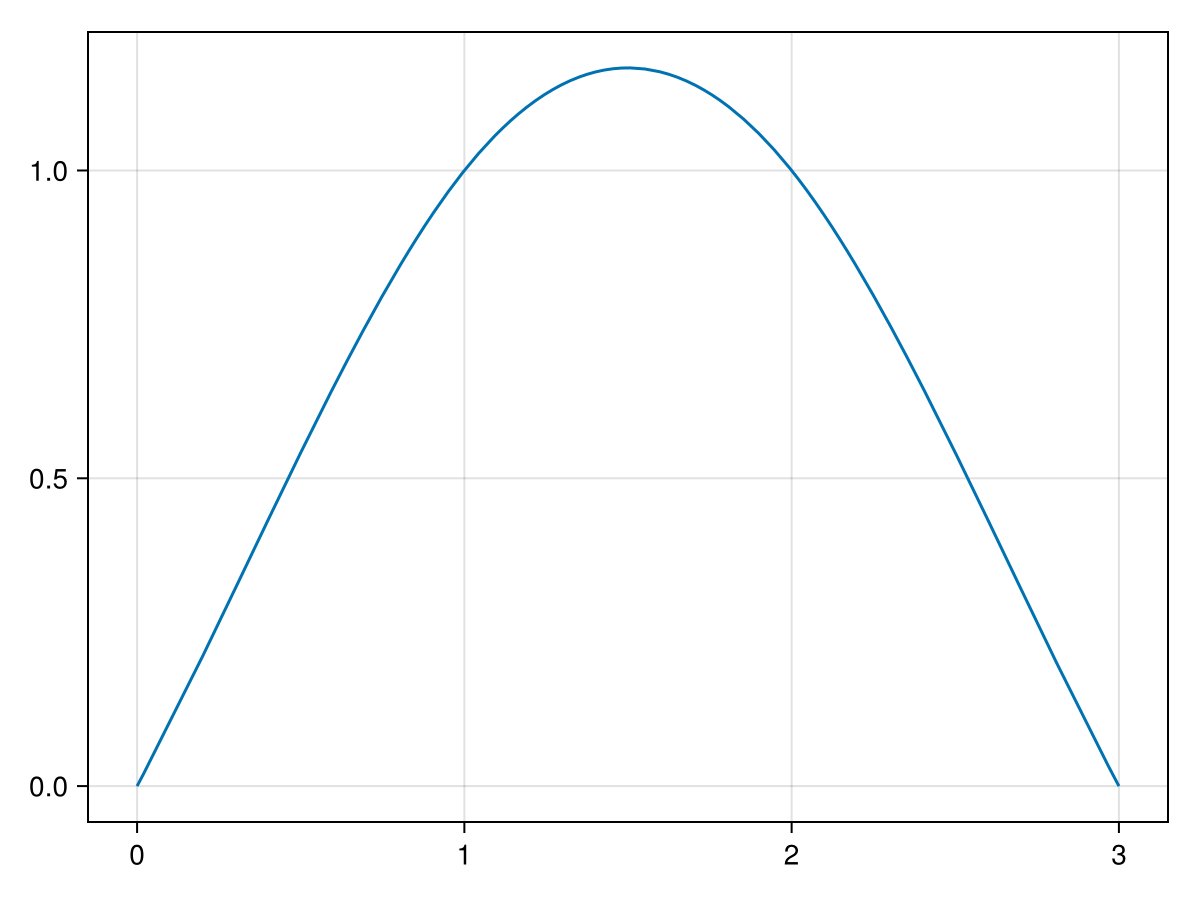

In [36]:
lines(0..3,x->f2(x))

## Generating the Coarse-graining maps

Now we can take our data structure, and generate cubic interpolations of these functions:

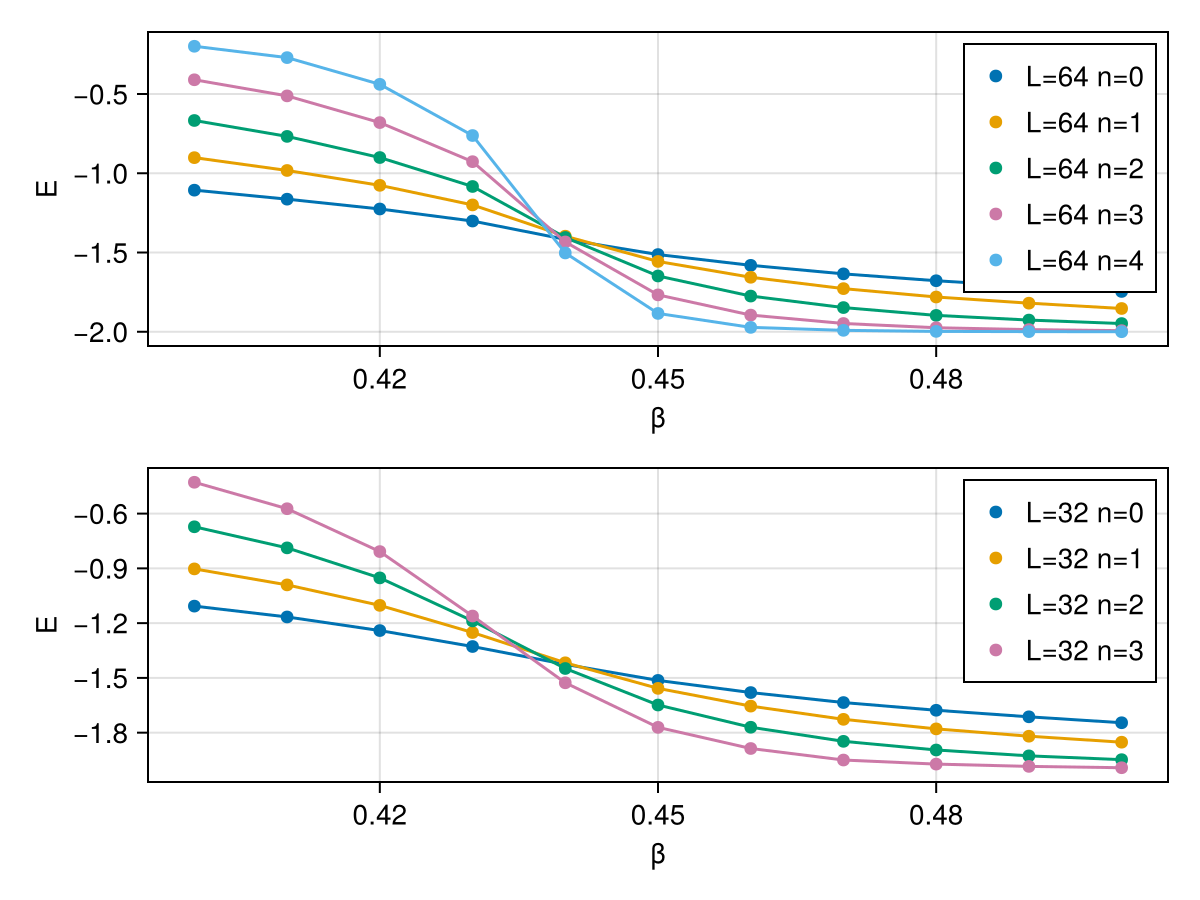

In [38]:
f=Figure()
ax1=Axis(f[1,1],xlabel="β",ylabel="E")
plotrgdata!(ax1,tstrgenergydata64)
axislegend()
ax2=Axis(f[2,1],xlabel="β",ylabel="E")
plotrgdata!(ax2,tstrgenergydata32)
axislegend()
f

In [39]:
tstrgenergydata64.usage

"`Elists[j,n]` is energy of coarse-grained energy of system of size `64` at inverse temperature `βlist[j]`, after `n` coarse graining steps.  `n` runs from 0 to 4"

In [84]:
function cginterpolations(data)
    Elists=data.Elists
    L=data.L
    betas=data.βlist
    maxn=data.maxn
    # forward functions
    Efuns=[CubicSpline(Elists[:,j],betas) for j in 0:maxn]
    # backward functions
    βfuns=[CubicSpline(reverse(betas),reverse(Elists[:,j])) for j in 0:maxn]
    return (L=L,maxn=maxn,betas=betas,Efuns=Efuns,βfuns=βfuns)
end

cginterpolations (generic function with 1 method)

In [155]:
interp64=cginterpolations(tstrgenergydata64);
interp32=cginterpolations(tstrgenergydata32);

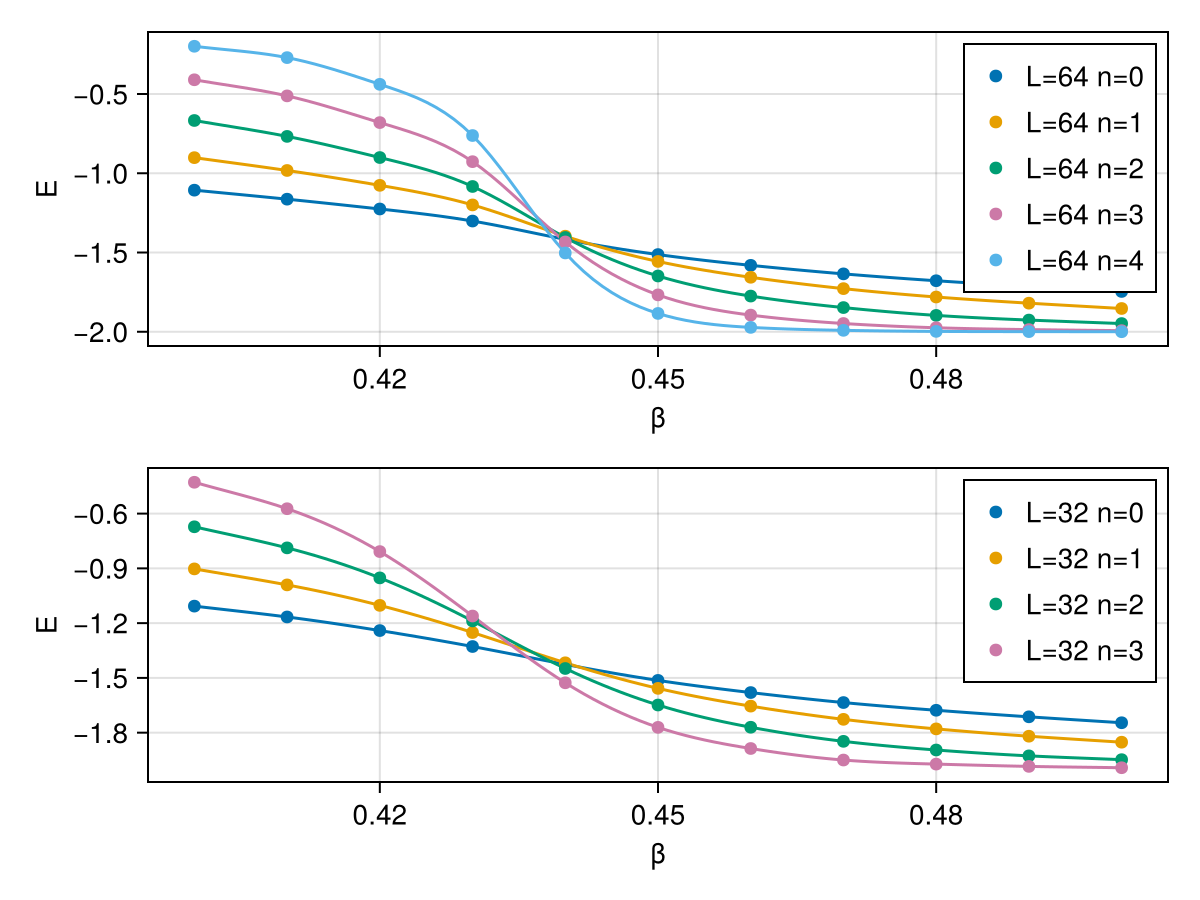

In [159]:
xvals=0.40:0.001:0.50
f=Figure()
ax1=Axis(f[1,1],xlabel="β",ylabel="E")
for f in interp64.Efuns
    lines!(ax1,xvals,f.(xvals))
end
plotrgpoints!(ax1,tstrgenergydata64)
axislegend()
ax2=Axis(f[2,1],xlabel="β",ylabel="E")
for f in interp32.Efuns
    lines!(ax2,xvals,f.(xvals))
end
plotrgpoints!(ax2,tstrgenergydata32)
axislegend()
f

We will now find $T_c$ by where $E_\beta(L,n)=E_{\beta}(L/2,n-1)$

In [55]:
using Roots

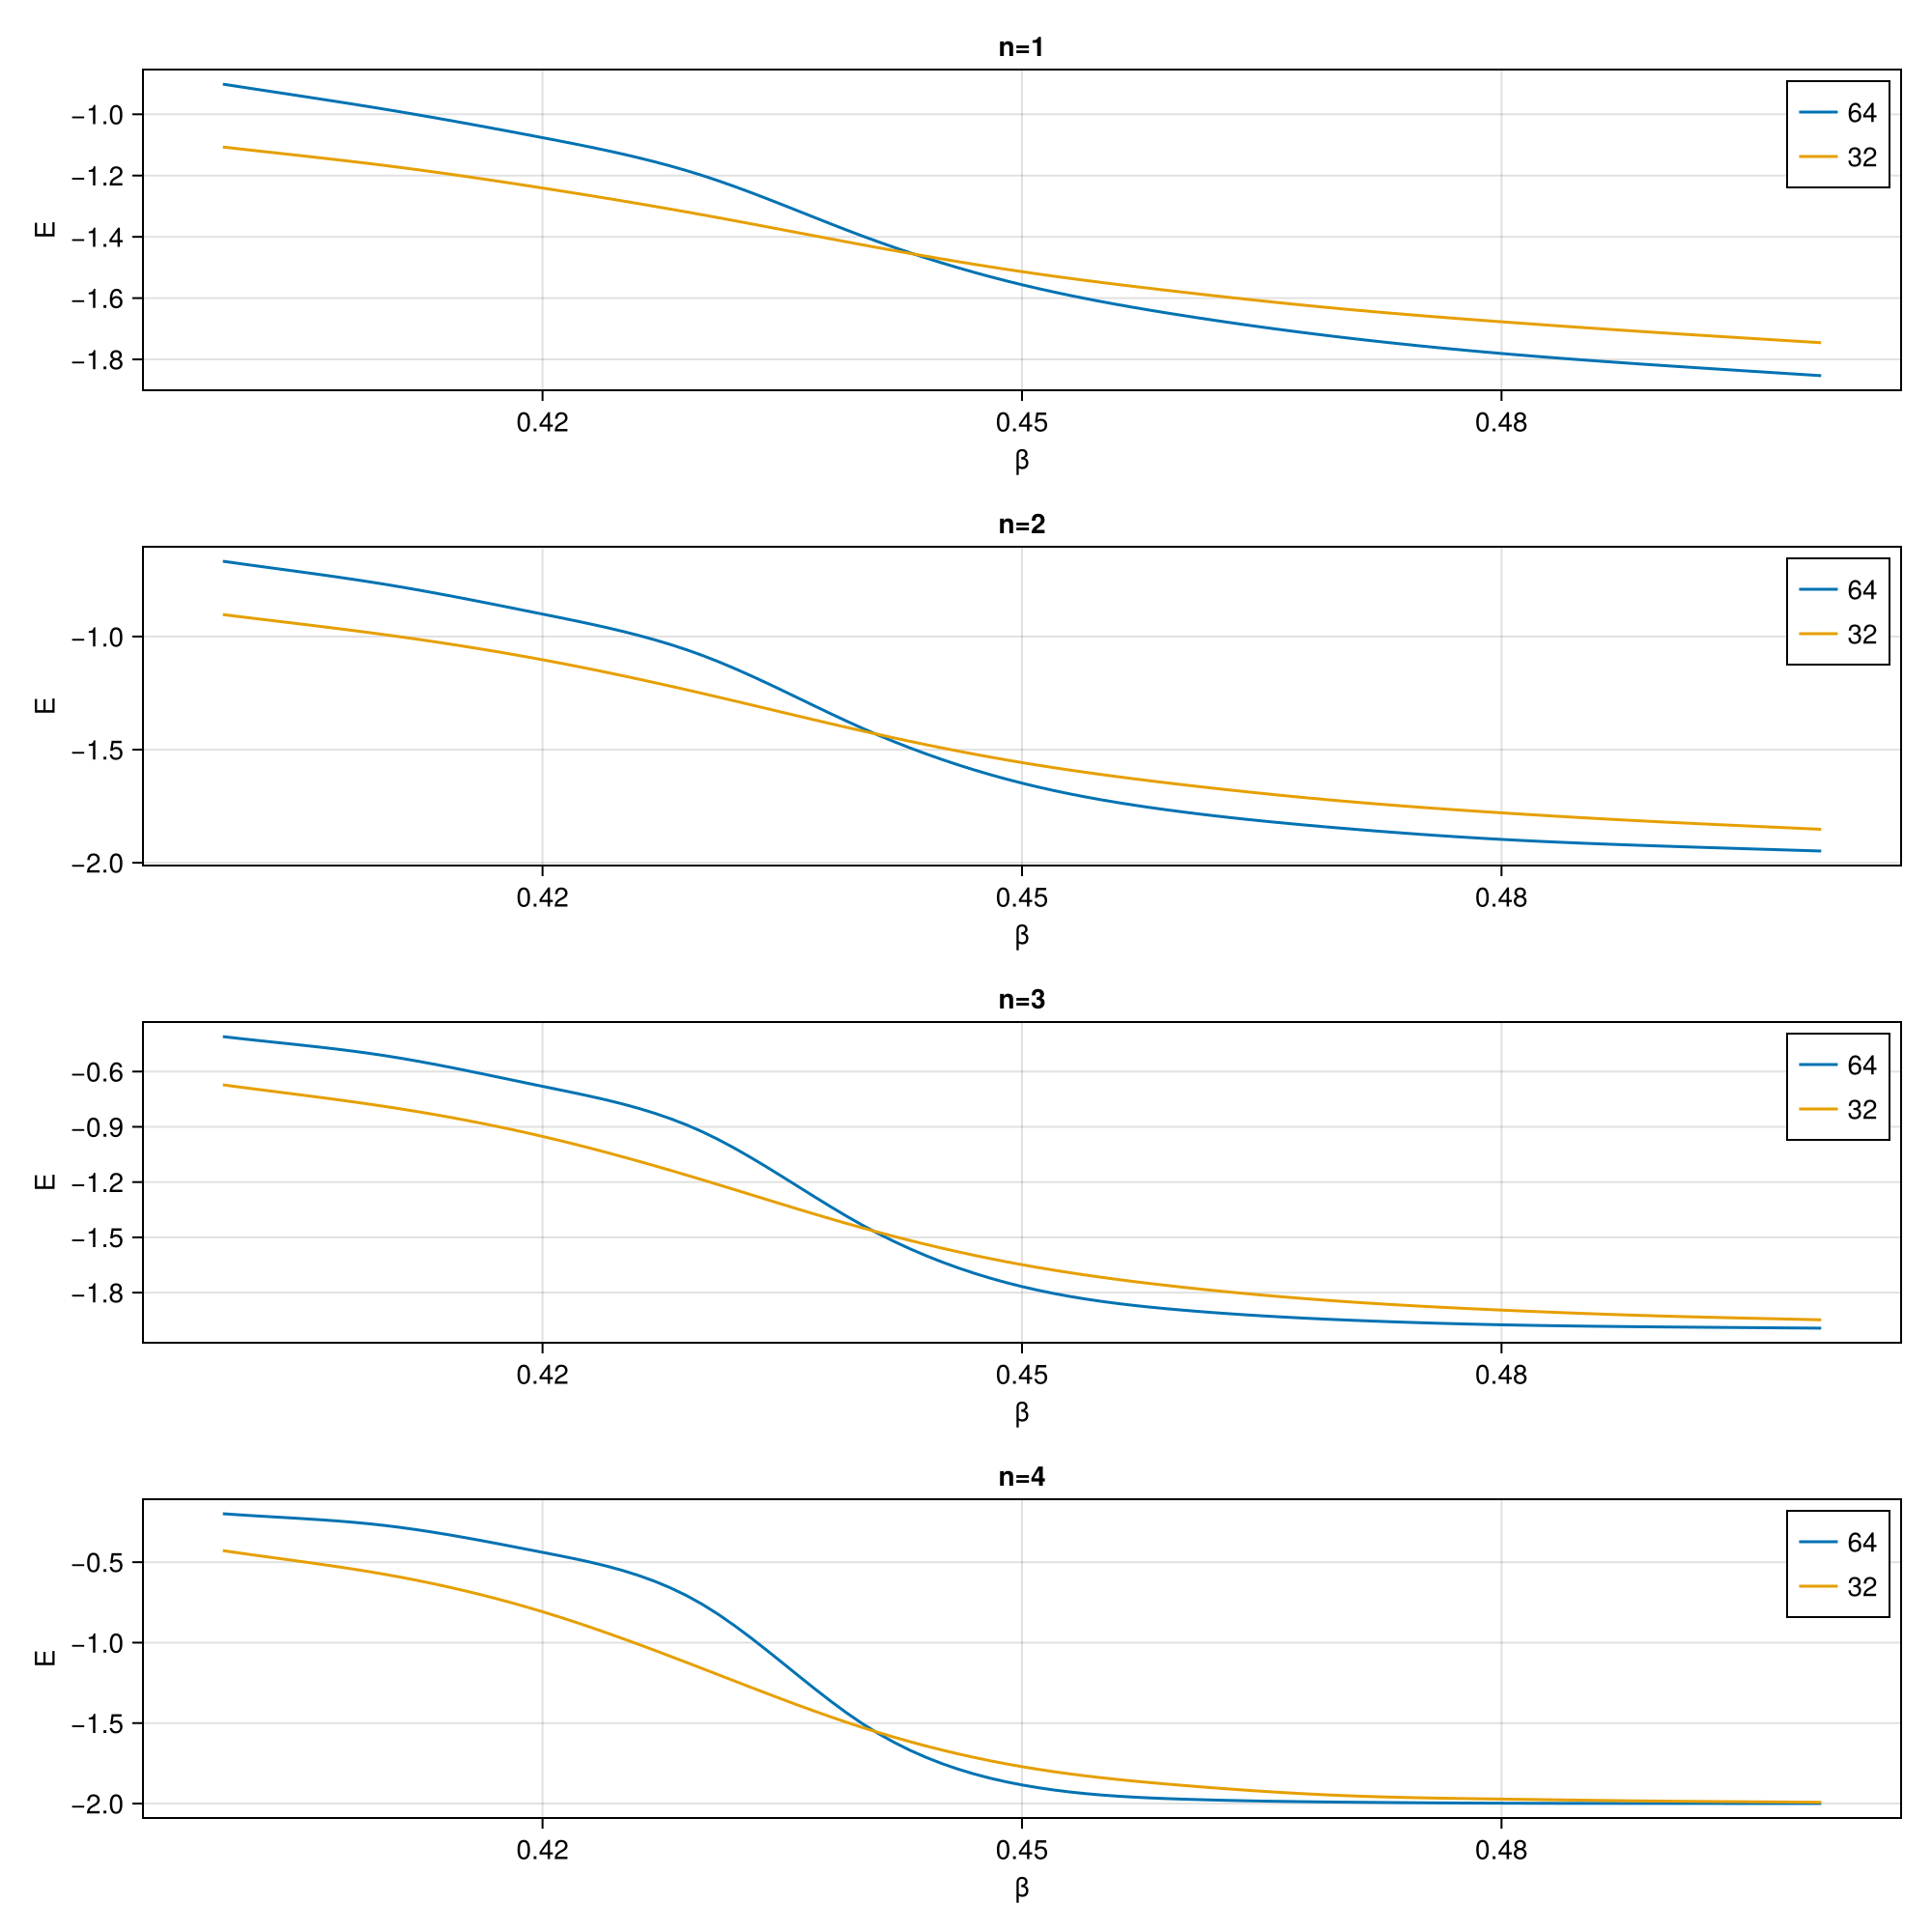

In [57]:
xvals=0.40:0.001:0.50
f=Figure(size=(1000,1000))
crossings=[]
for n in 1:4
    f64=interp64.Efuns[n+1]
    f32=interp32.Efuns[n]
    ax=Axis(f[n,1],xlabel="β",ylabel="E",title="n=$n")
    lines!(ax,xvals,f64.(xvals),label="64")
    lines!(ax,xvals,f32.(xvals),label="32")
    axislegend()
    betac=find_zero(x->f64(x)-f32(x),[0.44,0.45],Bisection())
    push!(crossings,betac)
end
f

In [58]:
crossings

4-element Vector{Any}:
 0.4432533755818119
 0.4408042099596832
 0.4406599248476356
 0.4407712492065891

Wow -- that is remarkable.  Using a moderate $L=64$, we get a quite respectable approximation to the true critical temperature

In [67]:
betac=log(1+sqrt(2))/2

0.44068679350977147

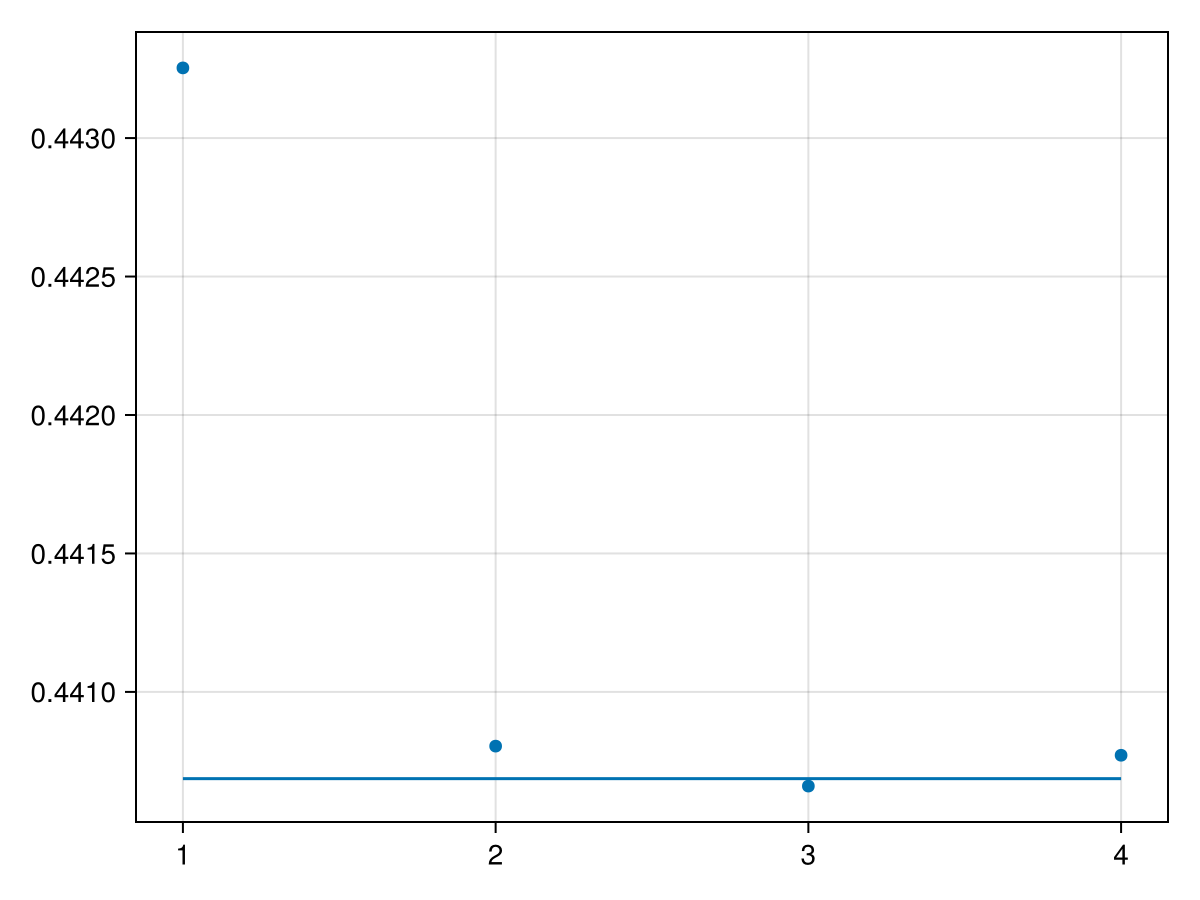

In [69]:
nlist=collect(1:4)
p=plot(nlist,[crossings...])
lines!([1,4],[betac,betac])
p

# Critical Exponents

In addition to finding the critical point, we can find the critical exponents.  The idea is that we can get a map between the temperatures of our two different finite size systems by solving the equation
\begin{equation}
E(\beta_1,L,n)=E(\beta_2,L/2,n-1)
\end{equation}
This gives us a function 
\begin{equation}
\beta_2=f(\beta_1).
\end{equation}
The critical point is the fixed point 
\begin{equation}
\beta_c=f(\beta_c).
\end{equation}
If these two distributions coarse grain to the same place in distribution space, then we must have the correlation lengths related by $\xi_1=2 \xi_2$.  Thus this function $f$ can be thought of as a map in function space that connects temperatures whose correlation lengths differ by a factor of 2.  IE  
\begin{equation}
\xi(\beta)=2\xi(f(\beta)).
\end{equation}

Lets linearize this map about the fixed point:
\begin{equation}
f(\beta_c+\delta\beta)=\beta_c+ \lambda \delta\beta,
\end{equation}
where
\begin{equation}
\lambda=\left.\frac{\partial f}{\partial\beta}\right|_{\beta=\beta_c}.
\end{equation}
It is convenient to rewrite this as
\begin{equation}
f(\beta)=\beta+ (\lambda-1)\delta\beta
\end{equation}

We then have
\begin{align}
\xi(\beta)&=2\xi(f(\beta))\\
&=2\xi(\beta)+2 \frac{\partial \xi}{\partial\beta} (\lambda-1) \delta\beta\\
\end{align}
which can be rearranged to
\begin{align}
\frac{1}{\xi} \frac{\partial \xi}{\partial\beta} &=-\frac{1}{(\lambda-1) (\beta-\beta_c)}.
\end{align}
This can be integrated to give
\begin{align}
\log(\xi)=-\frac{1}{\lambda-1}\log(\beta-\beta_c)+c
\end{align}
or 
\begin{equation}
\xi \propto (\beta-\beta_c)^{1/(\lambda-1)}.
\end{equation}
Hence the critical exponent is $\nu=1/(\lambda-1)$.

We know from our previous calculation that $\nu=1$ -- and hence we should find that $\lambda=2$.

Perhaps the simplest limit to think about is $n=1$.  Effectively, what we do is we start with a system of size $L$ at inverse temperature $\beta$.  We then coarse grain it to size $L/2$, and calculate the energy.  We then ask what $\beta^\prime$ gives that same energy for a system of size $L/2$.  We then have a physical picture that under coarse-graining $\beta\to \beta^\prime$.  The critical point is found as the fixed point of this map.  The critical exponent is given by linearizing the map about the fixed point. 

### Implementation

Implementation is simple:  We just compose the forward and backward maps:

In [195]:
betamap(x)=interp32.βfuns[2](interp64.Efuns[3](x))

betamap (generic function with 1 method)

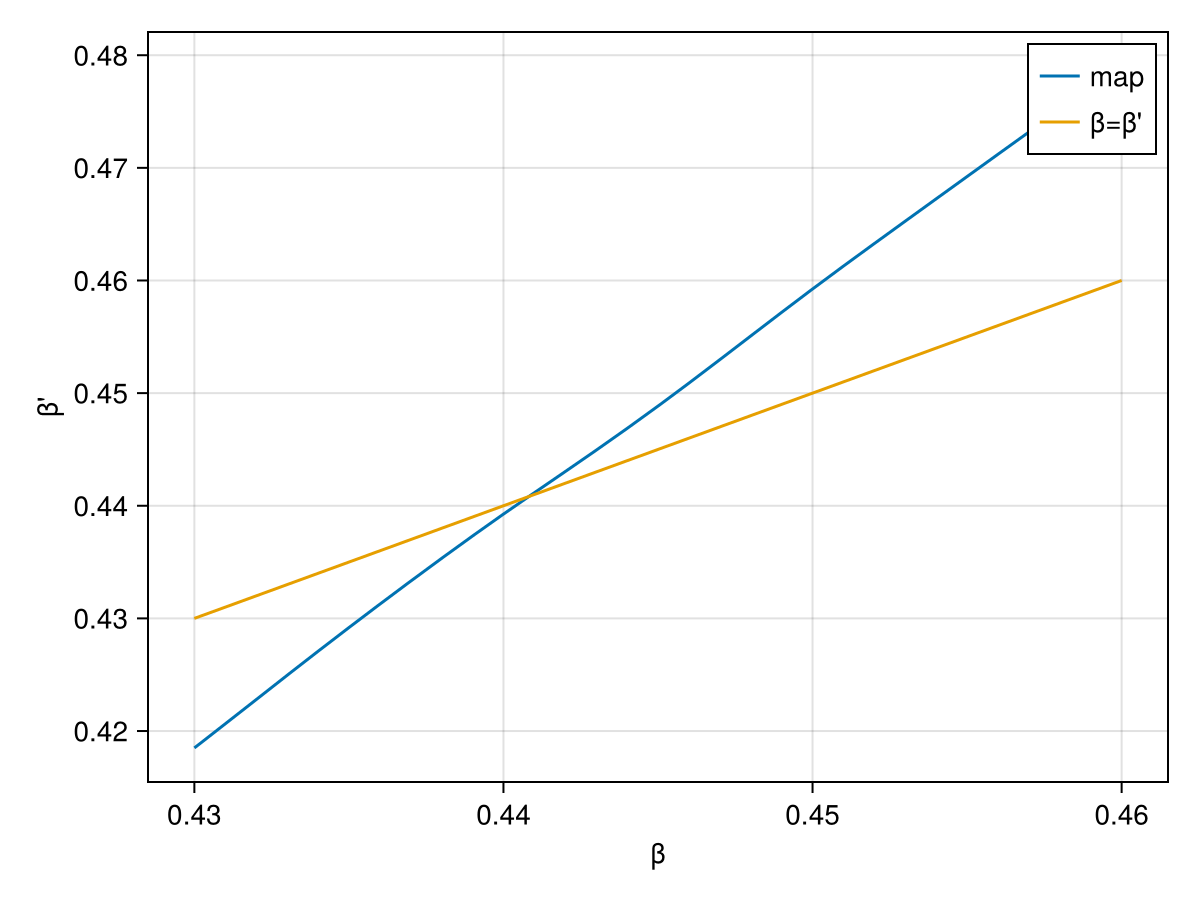

In [198]:
p=lines(0.43..0.46,betamap,label="map")
p.axis.xlabel="β"
p.axis.ylabel="β'"
lines!(0.43..0.46,x->x,label="β=β'")
axislegend()
p

To find the critical exponent we can use finite differences. 

In [204]:
δ=0.005
(betamap(betac+δ)-betamap(betac-δ))/(2*δ)

1.9630043780591688

That is reasonably close to te exact answer of $\lambda=2$.